# Louvain methods and analysis

Cell below analyses the results in the Louvain index file using the sensitivity analysis methods from previous work

,length of time series,number of time series compared,incidence mean,incidence std,expected noise:event ratio,max lag,number of populations,individuals within populations similar,individuals across populations similar,Z score mean (v1_sigma),...,v2 p-value,sqrt number_of_comparisons,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score
0,2700,15,0.29,0.07,0.66,55,3,False,True,2.73,...,0.48,5.48,2,0.55,1.00,0.71,2,0.26,0.53,0.35
1,1128,41,0.16,0.08,0.59,29,6,False,False,1.66,...,0.50,12.04,2,0.25,0.69,0.37,2,0.26,0.77,0.39
2,3610,25,0.19,0.05,1.59,54,3,True,False,3.24,...,1.00,10.30,2,0.71,0.96,0.82,2,0.71,0.96,0.82
3,2254,26,0.22,0.07,1.46,54,4,False,False,1.26,...,0.45,8.72,2,0.36,0.75,0.49,2,0.26,0.54,0.35
4,4079,30,0.23,0.04,1.53,17,7,True,False,0.84,...,0.95,8.37,3,0.31,0.64,0.41,1,0.16,1.00,0.28


,v1f_score,v2f_score
number of populations,-0.72,-0.64
number of time series compared,-0.36,-0.24
log ratio,-0.34,-0.39
expected noise:event ratio,-0.19,-0.15
number_of_comparisons,-0.18,-0.07
sqrt number_of_comparisons,-0.17,-0.05
incidence std,-0.11,-0.10
max lag,-0.06,-0.05
individuals across populations similar,0.01,-0.02
incidence mean,0.03,-0.13


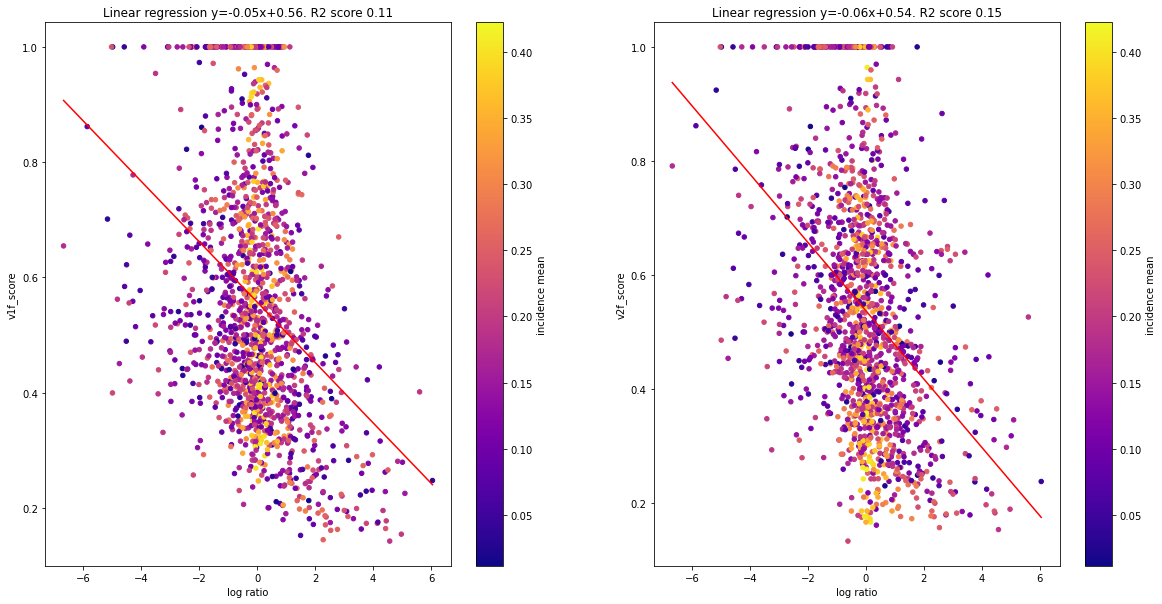

In [1]:
import sensitivity_analysis_functions as saf
import pandas as pd
#print(pd.__version__)
MI_analysis = False
linear_reg = True
regression_on_cols = ['v1f_score','v2f_score']
target_results_cols = ['v1f_score','v2f_score']

Louvain_version = '2'
df_correlations=pd.read_csv("..\Results\multiple_pop_correlations_index.csv",index_col = 0)
df_Louvain = pd.read_csv("..\Results\Louvain_{0}_results.csv".format(Louvain_version),index_col = 0)
#display(df_correlations.head(5))
#display(df_Louvain.head(5))
df = pd.concat([df_correlations,df_Louvain], axis = 1)

# show overall results 
meanv1_fscore = df.loc['v1f_score'].mean()
meanv2_fscore = df.loc['v2f_score'].mean()
df_similar = df.loc[df['individuals within populations similar'] == True]
meanv1_sim = df_similar.loc['v1f_score'].mean()
meanv2_sim = df_similar.loc['v2f_score'].mean()
print("Overall results for Louvain version {0}".format(Louvain_version))
print("Mean f-score for Louvain community detection for v1/v2 sigma across all results is {0}/{1}".format(meanv1_fscore,meanv2_fscore))
print("Mean f-score when only counting populations of similar individuals is {0}/{1}".format(meanv1_sim,meanv2_sim))

#display(df.head(5))

if MI_analysis:
    # for explanations of parameters/results headings set verbose to True
    # for MI comparisons against all versions of the results, set all_results to True
    # to display more/fewer MI values, reduce/increase cutoff
    # to display scattergraphs of all associations above cutoff value, set display_scattergraphs to True
    saf.mutual_information_analysis(df,verbose=False,all_results=False,target_results_cols = target_results_cols,cutoff=0.1,display_scattergraphs=True)
    
elif linear_reg:
    # linear regression will be on the feature passed as 'regression_feature' (useful to see scattergraphs even if regression line not meaningful in most cases)
    # if only_similar_individuals is True, half the runs will be discarded (those which cannot be meaningfully analysed using v2 sigma)
    # if only_similar_individuals is False, all runs will be included (so half of the v2 sigma results will be noise).
    # color_map_col can be changed to any feature parameter and will color the scatterplot by this parameter.
    saf.linear_regression_analysis(df,regression_feature = 'log ratio', regression_on_cols = regression_on_cols, only_similar_individuals = True,
                               color_map_col = 'incidence mean')




Cell below reads in the index file for Louvain results and continues to run Louvain on the corresponding correlation raw data from the last index.  An index can be passed in if it is required to repeat from a certain point.

In [4]:
import pointwise_correlation as pc
import testing_and_analysis_functions as taf
import pandas as pd
import Louvain
import numpy as np
import os

Louvain_version = '2'
Louvain_index_file = "{0}/Louvain_{1}_results.csv".format(pc.RESULTS_DIR,Louvain_version)
next_index = None

# turn index of correlation results into dataframe
index_df=pd.read_csv("{0}".format(pc.INDEX_FILE),index_col = 0)
# load completed results csv into dataframe if it already exists
try:
    Louvain_results = pd.read_csv(Louvain_index_file, index_col = 0)
    # set next_index to the index to start running from
    if next_index:
        Louvain_results = Louvain_results.head(next_index)    
    else:
        next_index = Louvain_results.index[-1] + 1    
except FileNotFoundError:
    Louvain_results = pd.DataFrame()
    next_index = 0


# iterate through the stored index file, load the corresponding raw data and carry out Louvain community detection
# the partition and the scores are written to csv files in a sub-directory of the raw data directory
for index in index_df.index[next_index:]:
    data_dir = index_df.loc[index,'raw data directory']
    number_of_populations = index_df.loc[index,'number of populations']
    results_path = os.path.join(data_dir,"Louvain_{0}".format(Louvain_version))
    try:
        os.mkdir(results_path)
    except FileExistsError:
        pass
    v1_df, v2_df = taf.load_results_to_dfs(data_dir)
    meta_params = pd.read_csv("{0}/meta_params.csv".format(data_dir))
    params = pd.read_csv("{0}/population_parameters.csv".format(data_dir))
    
    results = {}
    for i, df in enumerate([v1_df, v2_df]):
        sigma_version = "v" + str(i+1)
        L_methods = Louvain.Louvain_methods(df,p_values_graph_setup_option = 'weights',resolution = 1,
                                                    store_results_dir = results_path, version = sigma_version, 
                                                    Louvain_version = Louvain_version, verbose=False)
    
        results[sigma_version] = L_methods.score_partition()#n.make_partition_and_score(df,test_random_graph=False,pass_weights=True,resolution = 1,
                                                    #store_results_dir = results_path, version = sigma_version, Louvain_version = Louvain_version, verbose=False)
    
    # append v2 results to v1 results in dict
    results['v1'].update(results['v2'])

    new_row = pd.DataFrame.from_dict(results['v1'])
    new_row['Louvain results path'] = results_path
    new_row['n'] = number_of_populations
    new_row.index = [index]
    if len(Louvain_results.index):
        Louvain_results = pd.concat([Louvain_results, new_row])
    else:
        Louvain_results = new_row
    
    if index == index_df.index[-1] or not index%30:
        # store accumulated results in csv file
        Louvain_results.to_csv(Louvain_index_file)
        print("{0}%".format(int(index/30), end = ","))
        display(Louvain_results.tail(1))
        
        print("Testing by reloading stored results....")
        print("Scores for v1...")
        display(pd.read_csv("{0}/Louvain_{1}/v1recall_precision_fscores.csv".format(data_dir, Louvain_version)))
        print("...and v2")
        display(pd.read_csv("{0}/Louvain_{1}/v2recall_precision_fscores.csv".format(data_dir, Louvain_version)))
        print("Confusion matrices for v1...")
        display(pd.read_csv("{0}/Louvain_{1}/v1confusion_matrix.csv".format(data_dir, Louvain_version)))
        print("...and v2")
        display(pd.read_csv("{0}/Louvain_{1}/v2confusion_matrix.csv".format(data_dir, Louvain_version)))
        
           
    
    
    
    

1%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
30,2,0.166,0.665,0.265,9,0.205,0.279,0.237,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.043,0.042,0.071,0.079,0.092,0.058,0.101,0.19,0.166
1,Precison,0.467,1.000,1.000,0.714,0.611,0.524,0.491,1.00,0.665
2,F-score,0.079,0.080,0.133,0.142,0.161,0.105,0.167,0.32,0.265


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.030,0.056,0.044,0.057,0.115,0.077,0.115,0.368,0.205
1,Precison,0.067,1.000,0.200,0.190,0.306,0.143,0.182,0.583,0.279
2,F-score,0.042,0.105,0.073,0.088,0.167,0.100,0.141,0.452,0.237


Confusion matrices for v1...


,Unnamed: 0,5,4,0,3,2,6,1,7
0,cluster 0,5,7,4,6,5.0,4,NaN,NaN
1,cluster 1,2,2,2,1,NaN,7,3.0,9.0


...and v2


,Unnamed: 0,5,1,6,3,4,7,0,2
0,cluster 0,1.0,3.0,4.0,3.0,5.0,1.0,1.0,2.0
1,cluster 1,1.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0
2,cluster 4,3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,cluster 5,1.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN
4,cluster 6,1.0,NaN,NaN,1.0,NaN,7.0,NaN,NaN
5,cluster 2,NaN,NaN,1.0,NaN,1.0,1.0,1.0,NaN
6,cluster 3,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN
7,cluster 7,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN
8,cluster 8,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0


2%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
60,3,0.233,0.714,0.351,2,0.111,0.512,0.183,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.061,0.100,0.153,0.109,0.25,0.109,0.167,0.150,0.233
1,Precison,0.333,0.524,0.714,0.714,1.00,0.714,0.714,1.000,0.714
2,F-score,0.104,0.168,0.252,0.189,0.40,0.189,0.270,0.261,0.351


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.058,0.049,0.049,0.066,0.049,0.077,0.058,0.066,0.111
1,Precison,0.524,0.429,0.429,0.524,0.429,0.714,0.524,0.524,0.512
2,F-score,0.104,0.088,0.088,0.118,0.088,0.140,0.104,0.118,0.183


Confusion matrices for v1...


,Unnamed: 0,5,7,0,1,3,2,6,4
0,cluster 0,6.0,7.0,2,2.0,6.0,1.0,NaN,NaN
1,cluster 2,1.0,NaN,1,NaN,NaN,6.0,1.0,7.0
2,cluster 1,NaN,NaN,4,5.0,1.0,NaN,6.0,NaN


...and v2


,Unnamed: 0,5,1,2,6,0,3,4,7
0,cluster 0,6,4,4,5,5,2,4,2
1,cluster 1,1,3,3,2,2,5,3,5


3%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
90,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Flo,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen
0,cluster 0,15.0,NaN
1,cluster 1,NaN,15.0


...and v2


,Unnamed: 0,Flo,Owen
0,cluster 0,15.0,NaN
1,cluster 1,NaN,15.0


4%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
120,4,0.254,0.659,0.367,2,0.111,0.49,0.181,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.097,0.151,0.085,0.160,0.409,0.184,0.174,0.100,0.254
1,Precison,0.487,0.846,0.487,0.846,0.718,0.538,0.846,0.500,0.659
2,F-score,0.162,0.256,0.145,0.269,0.521,0.275,0.288,0.167,0.367


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.057,0.063,0.063,0.057,0.057,0.057,0.063,0.057,0.111
1,Precison,0.462,0.538,0.538,0.462,0.462,0.462,0.538,0.462,0.490
2,F-score,0.101,0.112,0.112,0.101,0.101,0.101,0.112,0.101,0.181


Confusion matrices for v1...


,Unnamed: 0,4,3,6,2,0,7,5,1
0,cluster 0,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,2.0,NaN,12.0,8.0,9.0,1.0,4.0,1.0
2,cluster 3,NaN,12.0,NaN,5.0,2.0,9.0,NaN,12.0
3,cluster 2,NaN,NaN,1.0,NaN,2.0,3.0,9.0,NaN


...and v2


,Unnamed: 0,6,4,1,5,2,0,7,3
0,cluster 0,9,7,9,7,9,7,7,7
1,cluster 1,4,6,4,6,4,6,6,6


5%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
150,5,0.4,0.663,0.499,3,0.137,0.405,0.204,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.300,0.0,0.133,0.415,0.273,0.026,0.217,0.344,0.400
1,Precison,1.000,0.0,0.286,0.611,1.000,0.333,1.000,0.489,0.663
2,F-score,0.462,0.0,0.182,0.494,0.429,0.048,0.357,0.404,0.499


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.056,0.0,0.065,0.129,0.065,0.050,0.059,0.102,0.137
1,Precison,0.333,0.0,0.429,0.361,0.429,1.000,0.467,0.400,0.405
2,F-score,0.096,0.0,0.113,0.190,0.113,0.095,0.104,0.162,0.204


Confusion matrices for v1...


,Unnamed: 0,6,4,2,5,3,1,7,0
0,cluster 0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,NaN,NaN,1.0,NaN,NaN,1.0,7.0,NaN
2,cluster 3,NaN,NaN,1.0,2.0,2.0,NaN,2.0,7.0
3,cluster 4,NaN,NaN,4.0,NaN,NaN,NaN,1.0,NaN
4,cluster 1,NaN,NaN,NaN,NaN,7.0,1.0,NaN,NaN


...and v2


,Unnamed: 0,3,0,7,6,2,1,4,5
0,cluster 0,3,2,6,2.0,4.0,1.0,4.0,NaN
1,cluster 1,1,4,3,4.0,3.0,1.0,3.0,3.0
2,cluster 2,5,1,1,NaN,NaN,NaN,NaN,NaN


6%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
180,3,0.327,0.918,0.482,16,0.401,0.397,0.399,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.273,0.273,0.198,0.184,0.169,0.184,0.184,0.140,0.327
1,Precison,1.000,1.000,0.895,1.000,0.801,1.000,1.000,0.649,0.918
2,F-score,0.429,0.429,0.325,0.310,0.279,0.310,0.310,0.231,0.482


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.130,0.218,0.112,0.115,0.712,0.840,0.106,0.122,0.401
1,Precison,0.257,0.702,0.135,0.099,0.795,0.795,0.105,0.287,0.397
2,F-score,0.173,0.333,0.122,0.107,0.751,0.817,0.106,0.171,0.399


Confusion matrices for v1...


,Unnamed: 0,6,3,5,4,2,7,1,0
0,cluster 0,19.0,19.0,19.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,NaN,17.0,18.0,15.0,NaN,NaN
2,cluster 2,NaN,NaN,NaN,NaN,1.0,4.0,19.0,19.0


...and v2


,Unnamed: 0,6,2,1,3,7,5,0,4
0,cluster 0,3.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN
2,cluster 2,2.0,4.0,16.0,2.0,10.0,NaN,8.0,NaN
3,cluster 4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,17.0
4,cluster 7,4.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
5,cluster 9,1.0,1.0,NaN,3.0,1.0,NaN,NaN,NaN
6,cluster 10,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN
7,cluster 14,4.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
8,cluster 3,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0
9,cluster 11,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN


7%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
210,3,0.446,0.944,0.606,2,0.28,0.844,0.421,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.350,0.733,0.053,0.019,0.040,0.538,0.088,0.019,0.038,0.446
1,Precison,1.000,1.000,1.000,1.000,1.000,1.000,0.500,1.000,1.000,0.944
2,F-score,0.519,0.846,0.100,0.037,0.077,0.700,0.150,0.037,0.074,0.606


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.333,0.114,0.037,0.0,0.015,0.269,0.062,0.015,0.011,0.280
1,Precison,1.000,0.591,1.000,0.0,1.000,1.000,0.444,1.000,0.333,0.844
2,F-score,0.500,0.191,0.071,0.0,0.030,0.424,0.110,0.030,0.022,0.421


Confusion matrices for v1...


,Unnamed: 0,5,2,6,1,4,0,3,8,7
0,cluster 0,15.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,NaN,NaN,6.0,NaN,NaN,15.0,2.0,3.0,2.0
2,cluster 1,NaN,NaN,NaN,12.0,2.0,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,5,1,6,7,3,4,8,2,0
0,cluster 0,15.0,9,4,2.0,1,2.0,1,NaN,NaN
1,cluster 1,NaN,3,5,NaN,1,NaN,2,3.0,15.0


8%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
240,3,0.531,1.0,0.694,4,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Tom,Rosa,Overall
0,Recall,1.0,1.0,0.400,0.167,0.531
1,Precison,1.0,1.0,1.000,1.000,1.000
2,F-score,1.0,1.0,0.571,0.286,0.694


...and v2


,Unnamed: 0,Owen,Elena,Tom,Rosa,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Elena,Tom,Rosa,Owen
0,cluster 0,2.0,NaN,NaN,NaN
1,cluster 1,NaN,5.0,3.0,NaN
2,cluster 2,NaN,NaN,NaN,3.0


...and v2


,Unnamed: 0,Elena,Tom,Owen,Rosa
0,cluster 0,2.0,NaN,NaN,NaN
1,cluster 1,NaN,5.0,NaN,NaN
2,cluster 2,NaN,NaN,3.0,NaN
3,cluster 3,NaN,NaN,NaN,3.0


9%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
270,4,0.512,0.91,0.655,6,0.918,0.936,0.927,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.261,0.185,0.695,0.261,1.0,0.375,0.512
1,Precison,1.000,0.615,0.846,1.000,1.0,1.000,0.910
2,F-score,0.414,0.285,0.763,0.414,1.0,0.545,0.655


...and v2


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.667,1.0,1.0,0.552,1.0,1.0,0.918
1,Precison,1.000,1.0,1.0,0.615,1.0,1.0,0.936
2,F-score,0.800,1.0,1.0,0.582,1.0,1.0,0.927


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Luke,Tom,Owen,Jill
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,10.0,13.0,NaN,NaN,NaN
2,cluster 2,NaN,3.0,NaN,13.0,13.0,1.0
3,cluster 3,NaN,NaN,NaN,NaN,NaN,12.0


...and v2


,Unnamed: 0,Rosa,Jill,Flo,Tom,Owen,Luke
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,13.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,10.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,3.0,13.0,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,13.0


10%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
300,2,0.846,0.688,0.759,2,0.538,0.438,0.483,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Rosa,Overall
0,Recall,0.833,0.333,0.846
1,Precison,0.667,1.000,0.688
2,F-score,0.741,0.500,0.759


...and v2


,Unnamed: 0,Jill,Rosa,Overall
0,Recall,0.500,0.143,0.538
1,Precison,0.400,1.000,0.438
2,F-score,0.444,0.250,0.483


Confusion matrices for v1...


,Unnamed: 0,Rosa,Jill
0,cluster 0,2.0,1
1,cluster 1,NaN,5


...and v2


,Unnamed: 0,Jill,Rosa
0,cluster 0,3,2.0
1,cluster 1,3,NaN


11%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
330,4,0.564,0.968,0.712,4,0.5,0.974,0.661,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.209,0.294,0.444,0.714,0.0,0.138,1.0,0.564
1,Precison,1.000,1.000,1.000,1.000,0.0,0.524,1.0,0.968
2,F-score,0.346,0.455,0.615,0.833,0.0,0.218,1.0,0.712


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.537,0.088,1.0,0.319,0.016,0.107,1.0,0.500
1,Precison,0.800,1.000,1.0,1.000,1.000,1.000,1.0,0.974
2,F-score,0.643,0.161,1.0,0.484,0.032,0.194,1.0,0.661


Confusion matrices for v1...


,Unnamed: 0,5,1,4,6,2,0,3
0,cluster 0,5.0,6.0,1.0,NaN,NaN,NaN,NaN
1,cluster 3,2.0,NaN,1.0,NaN,NaN,NaN,16.0
2,cluster 1,NaN,NaN,NaN,5.0,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,NaN,17.0,10.0,NaN


...and v2


,Unnamed: 0,5,3,1,4,0,6,2
0,cluster 0,7.0,16.0,6.0,2.0,1.0,NaN,NaN
1,cluster 2,NaN,NaN,NaN,NaN,9.0,NaN,NaN
2,cluster 1,NaN,NaN,NaN,NaN,NaN,5.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,17.0


12%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
360,3,0.446,0.787,0.569,3,0.545,0.894,0.677,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Overall
0,Recall,0.238,0.176,0.0,0.60,0.556,0.446
1,Precison,0.667,0.600,0.0,1.00,1.000,0.787
2,F-score,0.351,0.273,0.0,0.75,0.714,0.569


...and v2


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Overall
0,Recall,0.556,0.207,0.0,0.273,0.714,0.545
1,Precison,1.000,0.600,0.0,1.000,1.000,0.894
2,F-score,0.714,0.308,0.0,0.429,0.833,0.677


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen,Elena,Tom,Rosa
0,cluster 0,4.0,5.0,1.0,NaN,NaN
1,cluster 1,1.0,NaN,NaN,4.0,NaN
2,cluster 2,NaN,1.0,1.0,NaN,6.0


...and v2


,Unnamed: 0,Flo,Owen,Elena,Tom,Rosa
0,cluster 0,1.0,6.0,1.0,NaN,NaN
1,cluster 1,4.0,NaN,NaN,4.0,NaN
2,cluster 2,NaN,NaN,1.0,NaN,6.0


13%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
390,2,0.732,1.0,0.845,2,0.732,1.0,0.845,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Rosa,Overall
0,Recall,0.167,0.400,1.0,0.732
1,Precison,1.000,1.000,1.0,1.000
2,F-score,0.286,0.571,1.0,0.845


...and v2


,Unnamed: 0,Owen,Flo,Rosa,Overall
0,Recall,0.167,0.400,1.0,0.732
1,Precison,1.000,1.000,1.0,1.000
2,F-score,0.286,0.571,1.0,0.845


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Flo
0,cluster 0,8.0,NaN,NaN
1,cluster 1,NaN,3.0,5.0


...and v2


,Unnamed: 0,Rosa,Flo,Owen
0,cluster 0,8.0,NaN,NaN
1,cluster 1,NaN,5.0,3.0


14%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
420,3,0.501,0.956,0.658,2,0.235,0.633,0.342,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Overall
0,Recall,0.333,0.286,0.237,0.286,1.0,0.501
1,Precison,1.000,1.000,0.778,1.000,1.0,0.956
2,F-score,0.500,0.444,0.364,0.444,1.0,0.658


...and v2


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Overall
0,Recall,0.089,0.159,0.100,0.089,0.25,0.235
1,Precison,0.444,0.778,0.500,0.444,1.00,0.633
2,F-score,0.149,0.264,0.167,0.149,0.40,0.342


Confusion matrices for v1...


,Unnamed: 0,Rosa,Elena,Tom,Jill,Owen
0,cluster 0,9.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,9.0,9.0,1.0,NaN
2,cluster 2,NaN,NaN,NaN,8.0,9.0


...and v2


,Unnamed: 0,Rosa,Elena,Jill,Owen,Tom
0,cluster 0,9.0,1,3,4,4
1,cluster 1,NaN,8,6,5,5


15%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
450,3,1.0,1.0,1.0,2,0.319,0.49,0.386,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Jill,Rosa,Overall
0,Recall,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0


...and v2


,Unnamed: 0,Flo,Jill,Rosa,Overall
0,Recall,0.181,0.198,0.191,0.319
1,Precison,0.471,0.515,0.485,0.490
2,F-score,0.261,0.286,0.274,0.386


Confusion matrices for v1...


,Unnamed: 0,Jill,Rosa,Flo
0,cluster 0,17.0,NaN,NaN
1,cluster 1,NaN,17.0,NaN
2,cluster 2,NaN,NaN,17.0


...and v2


,Unnamed: 0,Jill,Rosa,Flo
0,cluster 0,11,7,9
1,cluster 1,6,10,8


16%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
480,2,0.845,0.848,0.847,2,0.798,0.807,0.802,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.721,0.743,0.845
1,Precison,0.801,0.895,0.848
2,F-score,0.759,0.812,0.847


...and v2


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.637,0.686,0.798
1,Precison,0.719,0.895,0.807
2,F-score,0.676,0.777,0.802


Confusion matrices for v1...


,Unnamed: 0,Owen,Elena
0,cluster 0,17,1
1,cluster 1,2,18


...and v2


,Unnamed: 0,Elena,Owen
0,cluster 0,18,3
1,cluster 1,1,16


17%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
510,2,0.868,1.0,0.93,2,0.868,1.0,0.93,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Tom,Rosa,Overall
0,Recall,0.091,0.500,1.0,0.868
1,Precison,1.000,1.000,1.0,1.000
2,F-score,0.167,0.667,1.0,0.930


...and v2


,Unnamed: 0,Owen,Tom,Rosa,Overall
0,Recall,0.091,0.500,1.0,0.868
1,Precison,1.000,1.000,1.0,1.000
2,F-score,0.167,0.667,1.0,0.930


Confusion matrices for v1...


,Unnamed: 0,Tom,Owen,Rosa
0,cluster 0,5.0,2.0,NaN
1,cluster 1,NaN,NaN,11.0


...and v2


,Unnamed: 0,Tom,Owen,Rosa
0,cluster 0,5.0,2.0,NaN
1,cluster 1,NaN,NaN,11.0


18%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
540,4,0.346,0.798,0.483,4,0.282,0.711,0.403,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.292,0.206,0.111,0.043,0.179,0.25,0.0,1.0,0.231,0.346
1,Precison,0.846,0.505,1.000,0.400,1.000,1.00,0.0,1.0,1.000,0.798
2,F-score,0.434,0.293,0.200,0.078,0.304,0.40,0.0,1.0,0.375,0.483


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.246,0.110,0.085,0.059,0.212,0.158,0.016,0.636,0.429,0.282
1,Precison,0.718,0.352,1.000,0.667,1.000,0.818,1.000,1.000,1.000,0.711
2,F-score,0.366,0.167,0.156,0.108,0.350,0.265,0.031,0.778,0.600,0.403


Confusion matrices for v1...


,Unnamed: 0,7,1,8,0,5,2,3,6,4
0,cluster 0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,9.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN
2,cluster 2,NaN,5.0,NaN,NaN,11.0,6.0,3.0,1.0,NaN
3,cluster 3,NaN,NaN,NaN,12.0,NaN,NaN,3.0,1.0,8.0


...and v2


,Unnamed: 0,1,5,8,7,4,3,0,2,6
0,cluster 0,3,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,2,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN
2,cluster 2,1,NaN,NaN,NaN,8.0,1.0,11.0,NaN,NaN
3,cluster 3,8,10.0,NaN,NaN,NaN,5.0,2.0,6.0,2.0


19%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
570,2,0.559,1.0,0.717,2,0.412,0.737,0.528,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Tom,Overall
0,Recall,0.167,0.400,1.0,0.559
1,Precison,1.000,1.000,1.0,1.000
2,F-score,0.286,0.571,1.0,0.717


...and v2


,Unnamed: 0,Flo,Elena,Tom,Overall
0,Recall,0.062,0.400,0.231,0.412
1,Precison,0.333,1.000,0.500,0.737
2,F-score,0.105,0.571,0.316,0.528


Confusion matrices for v1...


,Unnamed: 0,Tom,Elena,Flo
0,cluster 0,4.0,NaN,NaN
1,cluster 1,NaN,5.0,3.0


...and v2


,Unnamed: 0,Elena,Tom,Flo
0,cluster 0,5.0,1,2
1,cluster 1,NaN,3,1


20%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
600,3,0.247,0.596,0.349,8,0.136,0.25,0.176,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.19,0.150,0.022,0.111,0.179,0.097,0.109,0.259,0.247
1,Precison,1.00,1.000,1.000,1.000,1.000,0.308,0.314,1.000,0.596
2,F-score,0.32,0.261,0.043,0.200,0.304,0.148,0.162,0.412,0.349


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.043,0.025,0.016,0.067,0.127,0.086,0.089,0.045,0.136
1,Precison,0.167,0.095,1.000,0.667,1.000,0.141,0.133,0.214,0.250
2,F-score,0.069,0.040,0.032,0.122,0.226,0.107,0.106,0.075,0.176


Confusion matrices for v1...


,Unnamed: 0,0,3,6,5,1,4,2,7
0,cluster 0,9.0,6.0,7,4,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,4,3,7.0,8.0,2.0,NaN
2,cluster 2,NaN,NaN,4,6,NaN,NaN,NaN,8.0


...and v2


,Unnamed: 0,0,7,5,4,6,3,1,2
0,cluster 0,4.0,4.0,3.0,8.0,4.0,5.0,2.0,2.0
1,cluster 1,1.0,NaN,NaN,NaN,3.0,NaN,1.0,NaN
2,cluster 2,1.0,NaN,NaN,NaN,3.0,NaN,1.0,NaN
3,cluster 3,1.0,1.0,1.0,NaN,2.0,NaN,NaN,NaN
4,cluster 4,1.0,NaN,4.0,NaN,2.0,NaN,NaN,NaN
5,cluster 7,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN
6,cluster 5,NaN,1.0,2.0,NaN,NaN,NaN,2.0,NaN
7,cluster 6,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN


21%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
630,4,0.303,0.4,0.345,1,0.167,1.0,0.286,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Rosa,Luke,Overall
0,Recall,0.261,0.316,0.136,0.130,0.080,0.303
1,Precison,0.600,0.600,0.300,0.300,0.200,0.400
2,F-score,0.364,0.414,0.188,0.182,0.114,0.345


...and v2


,Unnamed: 0,Owen,Flo,Jill,Rosa,Luke,Overall
0,Recall,0.091,0.091,0.091,0.091,0.091,0.167
1,Precison,1.000,1.000,1.000,1.000,1.000,1.000
2,F-score,0.167,0.167,0.167,0.167,0.167,0.286


Confusion matrices for v1...


,Unnamed: 0,Rosa,Luke,Jill,Owen,Flo
0,cluster 0,3.0,2.0,1.0,NaN,NaN
1,cluster 1,1.0,2.0,NaN,4.0,NaN
2,cluster 3,1.0,NaN,1.0,NaN,4.0
3,cluster 2,NaN,1.0,3.0,1.0,1.0


...and v2


,Unnamed: 0,Rosa,Flo,Luke,Jill,Owen
0,cluster 0,5,5,5,5,5


22%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
660,3,0.337,0.707,0.456,6,0.165,0.228,0.192,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.152,0.185,0.028,0.238,0.067,0.412,0.0,0.337
1,Precison,0.667,0.476,0.333,1.000,1.000,0.778,0.0,0.707
2,F-score,0.247,0.267,0.051,0.385,0.125,0.538,0.0,0.456


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.026,0.079,0.0,0.179,0.040,0.138,0.040,0.165
1,Precison,0.067,0.143,0.0,0.467,1.000,0.222,1.000,0.228
2,F-score,0.038,0.102,0.0,0.259,0.077,0.170,0.077,0.192


Confusion matrices for v1...


,Unnamed: 0,5,0,6,1,2,4,3
0,cluster 0,8.0,1.0,1.0,1,1.0,NaN,NaN
1,cluster 1,1.0,NaN,1.0,5,NaN,2.0,NaN
2,cluster 2,NaN,5.0,NaN,1,2.0,NaN,6.0


...and v2


,Unnamed: 0,5,1,3,0,4,6,2
0,cluster 0,4.0,2.0,2.0,2.0,2.0,2.0,NaN
1,cluster 1,2.0,1.0,NaN,1.0,NaN,NaN,NaN
2,cluster 2,2.0,2.0,NaN,NaN,NaN,NaN,NaN
3,cluster 4,1.0,NaN,NaN,1.0,NaN,NaN,1.0
4,cluster 5,NaN,2.0,NaN,1.0,NaN,NaN,1.0
5,cluster 3,NaN,NaN,4.0,1.0,NaN,NaN,1.0


23%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
690,4,0.298,0.867,0.443,2,0.102,0.556,0.172,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.667,0.098,0.154,0.154,0.118,0.154,0.154,0.333,0.182,0.298
1,Precison,1.000,0.600,0.600,1.000,0.600,1.000,1.000,1.000,1.000,0.867
2,F-score,0.800,0.169,0.245,0.267,0.197,0.267,0.267,0.500,0.308,0.443


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.040,0.038,0.055,0.040,0.038,0.091,0.038,0.118,0.038,0.102
1,Precison,0.400,0.400,0.600,0.400,0.400,1.000,0.400,1.000,0.400,0.556
2,F-score,0.072,0.069,0.101,0.072,0.069,0.167,0.069,0.211,0.069,0.172


Confusion matrices for v1...


,Unnamed: 0,5,3,6,1,2,8,4,7,0
0,cluster 0,5.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,NaN,4.0,1.0,5.0,4.0,NaN,NaN
2,cluster 2,NaN,NaN,NaN,NaN,4.0,NaN,NaN,5.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0


...and v2


,Unnamed: 0,2,5,3,8,0,6,1,4,7
0,cluster 0,4,5.0,2,3,2,3,3,3,NaN
1,cluster 1,1,NaN,3,2,3,2,2,2,5.0


24%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
720,3,0.477,0.503,0.49,3,0.31,0.394,0.347,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Rosa,Overall
0,Recall,0.260,0.475,0.201,0.477
1,Precison,0.379,0.791,0.340,0.503
2,F-score,0.309,0.593,0.252,0.490


...and v2


,Unnamed: 0,Owen,Jill,Rosa,Overall
0,Recall,0.163,0.193,0.193,0.310
1,Precison,0.320,0.431,0.431,0.394
2,F-score,0.216,0.267,0.267,0.347


Confusion matrices for v1...


,Unnamed: 0,Owen,Rosa,Jill
0,cluster 0,9,9,NaN
1,cluster 1,7,4,2.0
2,cluster 2,2,5,16.0


...and v2


,Unnamed: 0,Owen,Jill,Rosa
0,cluster 0,8,10,10
1,cluster 1,4,1,1
2,cluster 2,6,7,7


25%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
750,3,0.765,0.605,0.675,2,0.58,0.93,0.714,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Luke,Jill,Overall
0,Recall,0.273,0.333,0.786,0.765
1,Precison,0.500,1.000,0.611,0.605
2,F-score,0.353,0.500,0.688,0.675


...and v2


,Unnamed: 0,Elena,Luke,Jill,Overall
0,Recall,0.094,0.333,0.571,0.580
1,Precison,0.500,1.000,1.000,0.930
2,F-score,0.158,0.500,0.727,0.714


Confusion matrices for v1...


,Unnamed: 0,Elena,Jill,Luke
0,cluster 0,3.0,2.0,NaN
1,cluster 2,1.0,NaN,2.0
2,cluster 1,NaN,7.0,NaN


...and v2


,Unnamed: 0,Jill,Elena,Luke
0,cluster 0,9.0,3,NaN
1,cluster 1,NaN,1,2.0


26%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
780,4,0.164,0.252,0.199,4,0.167,0.352,0.226,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.077,0.102,0.117,0.079,0.087,0.073,0.164
1,Precison,0.221,0.294,0.331,0.221,0.243,0.206,0.252
2,F-score,0.114,0.152,0.173,0.116,0.128,0.107,0.199


...and v2


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.105,0.091,0.115,0.073,0.072,0.080,0.167
1,Precison,0.456,0.324,0.515,0.279,0.235,0.301,0.352
2,F-score,0.171,0.142,0.188,0.116,0.111,0.126,0.226


Confusion matrices for v1...


,Unnamed: 0,Flo,Jill,Tom,Elena,Luke,Rosa
0,cluster 0,3,9,3,4,4,4
1,cluster 1,4,1,6,4,5,3
2,cluster 2,4,4,4,1,4,7
3,cluster 3,6,3,4,8,4,3


...and v2


,Unnamed: 0,Tom,Flo,Jill,Luke,Rosa,Elena
0,cluster 0,8,11.0,12.0,8,5,6
1,cluster 1,4,2.0,3.0,3,6,8
2,cluster 2,2,NaN,2.0,1,2,2
3,cluster 3,3,4.0,NaN,5,4,1


27%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
810,4,0.208,0.167,0.185,3,0.212,0.233,0.222,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Tom,Overall
0,Recall,0.143,0.143,0.067,0.208
1,Precison,0.200,0.200,0.100,0.167
2,F-score,0.167,0.167,0.080,0.185


...and v2


,Unnamed: 0,Owen,Flo,Tom,Overall
0,Recall,0.105,0.143,0.105,0.212
1,Precison,0.200,0.300,0.200,0.233
2,F-score,0.138,0.194,0.138,0.222


Confusion matrices for v1...


,Unnamed: 0,Tom,Flo,Owen
0,cluster 0,2,2.0,2.0
1,cluster 1,1,2.0,NaN
2,cluster 2,1,NaN,2.0
3,cluster 3,1,1.0,1.0


...and v2


,Unnamed: 0,Flo,Tom,Owen
0,cluster 0,3,2,2
1,cluster 1,1,2,1
2,cluster 2,1,1,2


28%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
840,4,0.416,0.875,0.564,6,0.708,0.959,0.815,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.333,0.208,0.116,0.500,0.063,0.314,0.429,0.122,0.416
1,Precison,1.000,0.846,0.455,1.000,0.321,1.000,1.000,1.000,0.875
2,F-score,0.500,0.334,0.185,0.667,0.106,0.478,0.600,0.217,0.564


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,1.0,1.0,0.750,0.875,0.636,0.333,0.094,0.128,0.708
1,Precison,1.0,1.0,0.818,1.000,1.000,1.000,0.524,1.000,0.959
2,F-score,1.0,1.0,0.783,0.933,0.778,0.500,0.159,0.227,0.815


Confusion matrices for v1...


,Unnamed: 0,1,0,4,3,2,7,5,6
0,cluster 0,12.0,16.0,3.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,NaN,NaN,NaN,5.0,6.0,12.0,NaN
2,cluster 1,NaN,NaN,1.0,15.0,6.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,4.0,NaN,NaN,NaN,NaN,7.0


...and v2


,Unnamed: 0,1,3,2,6,7,5,0,4
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,15.0,1.0,NaN,NaN,NaN,NaN,NaN
2,cluster 5,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,5.0,6.0,12.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,2.0,NaN,NaN,NaN,8.0
5,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN


29%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
870,3,0.203,0.467,0.283,3,0.22,0.511,0.308,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.143,0.200,0.122,0.093,0.053,0.028,0.115,0.091,0.203
1,Precison,0.412,1.000,1.000,0.324,0.600,0.267,0.375,1.000,0.467
2,F-score,0.212,0.333,0.217,0.145,0.098,0.051,0.176,0.167,0.283


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.195,0.148,0.116,0.100,0.042,0.042,0.132,0.128,0.220
1,Precison,0.471,1.000,1.000,0.352,0.600,0.400,0.433,1.000,0.511
2,F-score,0.276,0.258,0.208,0.155,0.079,0.076,0.202,0.227,0.308


Confusion matrices for v1...


,Unnamed: 0,0,2,5,3,4,6,7,1
0,cluster 0,8,6.0,3,3,1.0,3,NaN,NaN
1,cluster 1,8,NaN,1,7,NaN,9,6.0,NaN
2,cluster 2,1,NaN,2,5,4.0,4,NaN,9.0


...and v2


,Unnamed: 0,0,2,5,3,4,6,7,1
0,cluster 0,9.0,6.0,4,3,1.0,2,NaN,NaN
1,cluster 1,8.0,NaN,1,4,NaN,4,6.0,NaN
2,cluster 2,NaN,NaN,1,8,4.0,10,NaN,9.0


30%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
900,4,0.63,0.84,0.72,9,0.255,0.213,0.232,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.766,0.429,0.151,0.60,0.692,0.63
1,Precison,0.800,1.000,0.400,1.00,1.000,0.84
2,F-score,0.783,0.600,0.220,0.75,0.818,0.72


...and v2


,Unnamed: 0,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.123,0.269,0.060,0.113,0.210,0.255
1,Precison,0.200,0.156,0.089,0.156,0.467,0.213
2,F-score,0.153,0.197,0.071,0.131,0.290,0.232


Confusion matrices for v1...


,Unnamed: 0,Luke,Flo,Tom,Rosa,Jill
0,cluster 0,10.0,1.0,1.0,NaN,NaN
1,cluster 1,NaN,9.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,3.0,10.0,NaN
3,cluster 3,NaN,NaN,6.0,NaN,10.0


...and v2


,Unnamed: 0,Luke,Flo,Rosa,Tom,Jill
0,cluster 0,7.0,4.0,3.0,3.0,NaN
1,cluster 3,1.0,1.0,1.0,1.0,NaN
2,cluster 6,1.0,1.0,1.0,NaN,1.0
3,cluster 8,1.0,NaN,NaN,1.0,2.0
4,cluster 1,NaN,3.0,NaN,1.0,NaN
5,cluster 4,NaN,1.0,NaN,NaN,3.0
6,cluster 2,NaN,NaN,2.0,1.0,1.0
7,cluster 7,NaN,NaN,3.0,1.0,NaN
8,cluster 5,NaN,NaN,NaN,2.0,3.0


31%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
930,3,0.199,0.722,0.312,2,0.127,0.689,0.214,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.053,0.25,0.088,0.143,0.081,0.143,0.143,0.042,0.12,0.199
1,Precison,0.400,1.00,0.600,1.000,0.600,1.000,1.000,0.300,0.60,0.722
2,F-score,0.093,0.40,0.154,0.250,0.143,0.250,0.250,0.074,0.20,0.312


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.040,0.091,0.055,0.038,0.118,0.064,0.055,0.091,0.064,0.127
1,Precison,0.400,1.000,0.600,0.400,1.000,0.600,0.600,1.000,0.600,0.689
2,F-score,0.072,0.167,0.101,0.069,0.211,0.115,0.101,0.167,0.115,0.214


Confusion matrices for v1...


,Unnamed: 0,7,4,2,3,0,8,1,5,6
0,cluster 0,1,4.0,4.0,5.0,2.0,1.0,NaN,NaN,NaN
1,cluster 1,1,NaN,1.0,NaN,NaN,4.0,5.0,NaN,NaN
2,cluster 2,3,1.0,NaN,NaN,3.0,NaN,NaN,5.0,5.0


...and v2


,Unnamed: 0,7,1,2,5,3,6,8,0,4
0,cluster 0,5.0,5.0,4,1,3,4,1,2,NaN
1,cluster 1,NaN,NaN,1,4,2,1,4,3,5.0


32%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
960,5,0.735,1.0,0.847,6,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.316,1.0,0.316,1.0,1.0,1.0,0.735
1,Precison,1.000,1.0,1.000,1.0,1.0,1.0,1.000
2,F-score,0.480,1.0,0.480,1.0,1.0,1.0,0.847


...and v2


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Rosa,Tom,Luke,Owen,Jill,Flo
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,13.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,13.0,13.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Rosa,Tom,Luke,Owen,Flo,Jill
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,13.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,13.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,13.0,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,13.0


33%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
990,2,0.667,0.8,0.727,3,0.423,0.314,0.361,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Tom,Overall
0,Recall,0.333,0.091,0.778,0.667
1,Precison,1.000,1.000,0.750,0.800
2,F-score,0.500,0.167,0.764,0.727


...and v2


,Unnamed: 0,Owen,Jill,Tom,Overall
0,Recall,0.250,0.143,0.318,0.423
1,Precison,0.500,1.000,0.250,0.314
2,F-score,0.333,0.250,0.280,0.361


Confusion matrices for v1...


,Unnamed: 0,Owen,Tom,Jill
0,cluster 0,4.0,1,2.0
1,cluster 1,NaN,7,NaN


...and v2


,Unnamed: 0,Owen,Tom,Jill
0,cluster 0,3.0,2,NaN
1,cluster 1,1.0,3,NaN
2,cluster 2,NaN,3,2.0


34%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1020,2,0.212,0.813,0.337,3,0.31,0.825,0.451,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.176,0.107,0.101,0.087,0.132,0.134,0.107,0.212
1,Precison,1.000,0.800,0.644,0.644,0.800,1.000,0.800,0.813
2,F-score,0.300,0.189,0.175,0.153,0.227,0.237,0.189,0.337


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.176,0.145,0.176,0.087,0.145,0.257,0.429,0.310
1,Precison,1.000,0.622,1.000,0.356,0.800,1.000,1.000,0.825
2,F-score,0.300,0.235,0.300,0.140,0.245,0.409,0.600,0.451


Confusion matrices for v1...


,Unnamed: 0,5,6,3,1,2,4,0
0,cluster 0,10.0,9,8,9,2,1,NaN
1,cluster 1,NaN,1,2,1,8,9,10.0


...and v2


,Unnamed: 0,5,3,1,2,4,0,6
0,cluster 0,10.0,5,8,NaN,NaN,NaN,NaN
1,cluster 1,NaN,1,1,10.0,9.0,10.0,NaN
2,cluster 2,NaN,4,1,NaN,1.0,NaN,10.0


35%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1050,3,0.529,0.955,0.681,4,0.817,1.0,0.899,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.579,0.017,0.304,0.071,0.289,0.765,0.529
1,Precison,1.000,0.333,0.875,1.000,1.000,1.000,0.955
2,F-score,0.733,0.033,0.452,0.133,0.448,0.867,0.681


...and v2


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.647,0.059,0.714,0.077,1.0,1.0,0.817
1,Precison,1.000,1.000,1.000,1.000,1.0,1.0,1.000
2,F-score,0.786,0.111,0.833,0.143,1.0,1.0,0.899


Confusion matrices for v1...


,Unnamed: 0,Owen,Tom,Jill,Rosa,Flo,Luke
0,cluster 0,12.0,3.0,1.0,NaN,NaN,NaN
1,cluster 1,NaN,NaN,15.0,14.0,1.0,NaN
2,cluster 2,NaN,NaN,NaN,NaN,2.0,14.0


...and v2


,Unnamed: 0,Owen,Tom,Jill,Flo,Rosa,Luke
0,cluster 0,12.0,3.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,16.0,3.0,NaN,NaN
2,cluster 2,NaN,NaN,NaN,NaN,14.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,14.0


36%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1080,4,0.61,1.0,0.758,4,0.562,1.0,0.72,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Luke,Overall
0,Recall,1.0,0.400,0.111,0.429,1.0,0.167,0.610
1,Precison,1.0,1.000,1.000,1.000,1.0,1.000,1.000
2,F-score,1.0,0.571,0.200,0.600,1.0,0.286,0.758


...and v2


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.231,1.0,0.111,0.429,0.333,1.0,0.562
1,Precison,1.000,1.0,1.000,1.000,1.000,1.0,1.000
2,F-score,0.375,1.0,0.200,0.600,0.500,1.0,0.720


Confusion matrices for v1...


,Unnamed: 0,Tom,Elena,Flo,Luke,Owen,Rosa
0,cluster 0,4.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,5.0,3.0,NaN,NaN
2,cluster 2,NaN,NaN,NaN,NaN,4.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,5.0


...and v2


,Unnamed: 0,Tom,Elena,Flo,Luke,Owen,Rosa
0,cluster 0,4.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,5.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,3.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,4.0,5.0


37%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1110,3,0.283,0.739,0.41,3,0.317,0.87,0.465,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.091,0.231,0.333,0.111,0.067,0.200,0.283
1,Precison,1.000,1.000,0.500,0.500,1.000,1.000,0.739
2,F-score,0.167,0.375,0.400,0.182,0.125,0.333,0.410


...and v2


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.111,0.200,0.375,0.200,0.059,0.25,0.317
1,Precison,1.000,1.000,0.500,1.000,1.000,1.00,0.870
2,F-score,0.200,0.333,0.429,0.333,0.111,0.40,0.465


Confusion matrices for v1...


,Unnamed: 0,Luke,Owen,Elena,Tom,Flo,Rosa
0,cluster 0,3.0,2.0,1.0,1.0,NaN,NaN
1,cluster 1,NaN,NaN,3.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,3.0,4.0,2.0


...and v2


,Unnamed: 0,Luke,Owen,Elena,Flo,Tom,Rosa
0,cluster 0,3.0,2.0,1.0,NaN,NaN,NaN
1,cluster 1,NaN,NaN,3.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,4.0,4.0,2.0


38%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1140,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Tom,Rosa,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Rosa,Tom
0,cluster 0,4.0,NaN
1,cluster 1,NaN,6.0


...and v2


,Unnamed: 0,Rosa,Tom
0,cluster 0,4.0,NaN
1,cluster 1,NaN,6.0


39%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1170,4,0.344,0.74,0.47,2,0.133,0.506,0.211,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.330,0.182,0.079,0.370,0.263,0.217,0.182,0.344
1,Precison,0.655,0.673,0.364,0.673,1.000,1.000,0.818,0.740
2,F-score,0.439,0.287,0.130,0.477,0.417,0.357,0.298,0.470


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.065,0.064,0.091,0.064,0.065,0.073,0.077,0.133
1,Precison,0.455,0.455,0.673,0.455,0.455,0.491,0.564,0.506
2,F-score,0.114,0.112,0.160,0.112,0.114,0.126,0.135,0.211


Confusion matrices for v1...


,Unnamed: 0,6,5,0,2,3,1,4
0,cluster 0,10.0,11.0,1.0,5.0,2.0,NaN,NaN
1,cluster 1,1.0,NaN,9.0,1.0,NaN,2.0,NaN
2,cluster 2,NaN,NaN,1.0,NaN,9.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,5.0,NaN,9.0,11.0


...and v2


,Unnamed: 0,6,3,4,1,0,2,5
0,cluster 0,8,6,5,6,5,9,4
1,cluster 1,3,5,6,5,6,2,7


40%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1200,4,0.266,0.654,0.378,2,0.104,0.492,0.172,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.290,0.180,0.354,0.099,0.152,0.098,0.144,0.070,0.136,0.266
1,Precison,0.889,0.784,0.889,0.529,0.784,0.497,0.529,0.288,0.693,0.654
2,F-score,0.437,0.293,0.507,0.167,0.255,0.163,0.227,0.112,0.228,0.378


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.053,0.063,0.058,0.053,0.053,0.054,0.054,0.053,0.054,0.104
1,Precison,0.477,0.575,0.529,0.471,0.477,0.477,0.477,0.471,0.477,0.492
2,F-score,0.095,0.113,0.105,0.095,0.095,0.097,0.097,0.095,0.097,0.172


Confusion matrices for v1...


,Unnamed: 0,8,4,3,5,7,6,1,2,0
0,cluster 0,15.0,16.0,12.0,7.0,2,1,1.0,NaN,NaN
1,cluster 2,2.0,1.0,NaN,NaN,7,1,1.0,17.0,NaN
2,cluster 3,1.0,1.0,NaN,NaN,2,13,NaN,NaN,17.0
3,cluster 1,NaN,NaN,6.0,11.0,7,3,16.0,1.0,1.0


...and v2


,Unnamed: 0,8,1,4,2,5,3,0,7,6
0,cluster 0,8,13,10,12,8,9,10,9,8
1,cluster 1,10,5,8,6,10,9,8,9,10


41%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1230,3,0.378,0.913,0.535,4,0.462,1.0,0.632,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.750,0.099,0.200,0.273,0.200,0.273,0.378
1,Precison,1.000,0.476,1.000,1.000,1.000,1.000,0.913
2,F-score,0.857,0.164,0.333,0.429,0.333,0.429,0.535


...and v2


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,1.0,0.176,0.176,1.0,0.176,1.0,0.462
1,Precison,1.0,1.000,1.000,1.0,1.000,1.0,1.000
2,F-score,1.0,0.300,0.300,1.0,0.300,1.0,0.632


Confusion matrices for v1...


,Unnamed: 0,Luke,Tom,Elena,Flo,Rosa,Jill
0,cluster 0,7.0,7.0,1,NaN,NaN,NaN
1,cluster 1,NaN,NaN,1,7.0,NaN,NaN
2,cluster 2,NaN,NaN,5,NaN,7.0,7.0


...and v2


,Unnamed: 0,Luke,Flo,Rosa,Elena,Jill,Tom
0,cluster 0,7.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,7.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,7.0,7.0,7.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,7.0


42%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1260,3,0.28,0.77,0.41,5,0.335,0.469,0.391,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Jill,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.304,0.026,0.201,0.099,0.154,0.100,0.28
1,Precison,1.000,0.333,0.778,0.476,1.000,0.667,0.77
2,F-score,0.467,0.049,0.320,0.164,0.267,0.174,0.41


...and v2


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.368,0.258,0.0,0.154,0.080,0.022,0.335
1,Precison,1.000,0.444,0.0,0.286,0.200,0.067,0.469
2,F-score,0.538,0.327,0.0,0.200,0.114,0.033,0.391


Confusion matrices for v1...


,Unnamed: 0,Elena,Luke,Tom,Jill,Rosa,Flo
0,cluster 0,8.0,5.0,5,2.0,NaN,NaN
1,cluster 1,1.0,1.0,1,NaN,5.0,8.0
2,cluster 2,NaN,NaN,1,1.0,NaN,NaN


...and v2


,Unnamed: 0,Elena,Luke,Tom,Jill,Rosa,Flo
0,cluster 0,6.0,1,1.0,1.0,NaN,NaN
1,cluster 2,2.0,2,1.0,NaN,1.0,8.0
2,cluster 4,1.0,1,1.0,NaN,2.0,NaN
3,cluster 1,NaN,1,NaN,1.0,2.0,NaN
4,cluster 3,NaN,1,4.0,1.0,NaN,NaN


43%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1290,4,0.91,0.917,0.913,4,0.829,0.845,0.837,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.846,0.821,0.846,0.821,0.910
1,Precison,1.000,0.833,1.000,0.833,0.917
2,F-score,0.917,0.827,0.917,0.827,0.913


...and v2


,Unnamed: 0,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.846,0.672,0.733,0.575,0.829
1,Precison,1.000,0.682,1.000,0.697,0.845
2,F-score,0.917,0.677,0.846,0.630,0.837


Confusion matrices for v1...


,Unnamed: 0,Rosa,Luke,Tom,Elena
0,cluster 0,12.0,1.0,NaN,NaN
1,cluster 1,NaN,11.0,NaN,NaN
2,cluster 2,NaN,NaN,11.0,NaN
3,cluster 3,NaN,NaN,1.0,12.0


...and v2


,Unnamed: 0,Rosa,Luke,Tom,Elena
0,cluster 0,12.0,2.0,NaN,NaN
1,cluster 1,NaN,10.0,1.0,NaN
2,cluster 2,NaN,NaN,10.0,NaN
3,cluster 3,NaN,NaN,1.0,12.0


44%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1320,3,0.804,0.712,0.756,2,0.473,0.487,0.48,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.607,0.720,0.804
1,Precison,0.536,0.889,0.712
2,F-score,0.569,0.795,0.756


...and v2


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.314,0.305,0.473
1,Precison,0.497,0.477,0.487
2,F-score,0.385,0.372,0.480


Confusion matrices for v1...


,Unnamed: 0,Elena,Owen
0,cluster 0,17.0,3
1,cluster 2,1.0,2
2,cluster 1,NaN,13


...and v2


,Unnamed: 0,Elena,Owen
0,cluster 0,8,7
1,cluster 1,10,11


45%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1350,4,0.356,0.731,0.479,4,0.29,0.799,0.426,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.263,0.157,0.121,0.471,0.02,0.231,0.124,0.052,0.356
1,Precison,1.000,0.655,0.436,1.000,1.00,1.000,0.282,0.600,0.731
2,F-score,0.417,0.254,0.189,0.640,0.04,0.375,0.173,0.096,0.479


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.135,0.113,0.073,0.500,0.0,0.818,0.125,0.032,0.290
1,Precison,1.000,0.818,0.308,1.000,0.0,1.000,0.705,0.600,0.799
2,F-score,0.238,0.198,0.118,0.667,0.0,0.900,0.212,0.061,0.426


Confusion matrices for v1...


,Unnamed: 0,2,1,7,6,4,3,0,5
0,cluster 0,8.0,9.0,4.0,4,NaN,NaN,NaN,NaN
1,cluster 1,4.0,1.0,1.0,1,2.0,17.0,NaN,NaN
2,cluster 2,1.0,1.0,NaN,2,NaN,NaN,11.0,10.0
3,cluster 3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,2,1,7,0,4,6,3,5
0,cluster 0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,6.0,10.0,4.0,11.0,1.0,11.0,NaN,NaN
2,cluster 2,4.0,1.0,1.0,NaN,1.0,1.0,17.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,10.0


46%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1380,2,0.812,1.0,0.897,2,0.812,1.0,0.897,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Rosa,Overall
0,Recall,0.077,1.0,0.556,0.812
1,Precison,1.000,1.0,1.000,1.000
2,F-score,0.143,1.0,0.714,0.897


...and v2


,Unnamed: 0,Owen,Elena,Rosa,Overall
0,Recall,0.077,1.0,0.556,0.812
1,Precison,1.000,1.0,1.000,1.000
2,F-score,0.143,1.0,0.714,0.897


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Elena
0,cluster 0,6.0,2.0,NaN
1,cluster 1,NaN,NaN,9.0


...and v2


,Unnamed: 0,Elena,Rosa,Owen
0,cluster 0,9.0,NaN,NaN
1,cluster 1,NaN,6.0,2.0


47%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1410,4,0.274,0.708,0.395,8,0.803,0.902,0.85,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.145,0.412,0.172,0.030,0.094,0.294,0.123,0.065,0.400,0.274
1,Precison,0.750,1.000,0.691,0.238,0.400,1.000,1.000,0.400,1.000,0.708
2,F-score,0.243,0.583,0.276,0.054,0.153,0.455,0.220,0.111,0.571,0.395


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,1.0,0.636,0.889,0.060,0.588,1.0,1.0,0.625,0.60,0.803
1,Precison,1.0,1.000,1.000,0.238,0.638,1.0,1.0,1.000,1.00,0.902
2,F-score,1.0,0.778,0.941,0.095,0.612,1.0,1.0,0.769,0.75,0.850


Confusion matrices for v1...


,Unnamed: 0,2,4,7,6,3,8,1,0,5
0,cluster 0,14.0,9,7,10.0,2.0,NaN,NaN,NaN,NaN
1,cluster 3,3.0,1,1,NaN,NaN,NaN,NaN,7.0,11.0
2,cluster 1,NaN,4,2,NaN,3.0,13.0,NaN,NaN,NaN
3,cluster 2,NaN,1,1,NaN,2.0,NaN,8.0,1.0,NaN


...and v2


,Unnamed: 0,2,4,1,3,8,7,5,6,0
0,cluster 0,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,NaN,2.0,NaN,2.0,13.0,NaN,NaN,NaN,NaN
2,cluster 3,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cluster 1,NaN,NaN,8.0,2.0,NaN,NaN,NaN,NaN,NaN
4,cluster 4,NaN,NaN,NaN,3.0,NaN,11.0,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


48%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1440,3,0.619,0.958,0.752,9,0.265,0.182,0.216,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Jill,Elena,Rosa,Overall
0,Recall,0.846,0.314,0.314,0.821,0.619
1,Precison,1.000,1.000,1.000,0.833,0.958
2,F-score,0.917,0.478,0.478,0.827,0.752


...and v2


,Unnamed: 0,Flo,Jill,Elena,Rosa,Overall
0,Recall,0.088,0.163,0.093,0.210,0.265
1,Precison,0.091,0.242,0.061,0.333,0.182
2,F-score,0.090,0.195,0.073,0.257,0.216


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Jill,Elena
0,cluster 0,11.0,NaN,NaN,NaN
1,cluster 1,1.0,12.0,NaN,NaN
2,cluster 2,NaN,NaN,12.0,12.0


...and v2


,Unnamed: 0,Rosa,Elena,Flo,Jill
0,cluster 0,1.0,1.0,2.0,NaN
1,cluster 1,7.0,1.0,3.0,6.0
2,cluster 2,1.0,1.0,1.0,1.0
3,cluster 3,1.0,2.0,NaN,1.0
4,cluster 8,2.0,2.0,NaN,NaN
5,cluster 5,NaN,2.0,1.0,NaN
6,cluster 6,NaN,1.0,2.0,1.0
7,cluster 7,NaN,2.0,1.0,1.0
8,cluster 4,NaN,NaN,2.0,2.0


49%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1470,4,0.18,0.394,0.247,4,0.155,0.343,0.214,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.099,0.099,0.062,0.065,0.085,0.066,0.160,0.168,0.180
1,Precison,0.351,0.415,0.269,0.269,0.357,0.246,0.626,0.620,0.394
2,F-score,0.154,0.160,0.101,0.104,0.137,0.103,0.254,0.264,0.247


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.071,0.069,0.099,0.080,0.079,0.063,0.063,0.160,0.155
1,Precison,0.304,0.298,0.439,0.316,0.316,0.228,0.275,0.567,0.343
2,F-score,0.115,0.112,0.162,0.127,0.126,0.099,0.102,0.249,0.214


Confusion matrices for v1...


,Unnamed: 0,6,4,5,1,2,0,3,7
0,cluster 0,2.0,6,2,12,7,9.0,7,1
1,cluster 2,15.0,10,5,3,6,NaN,3,2
2,cluster 3,2.0,2,5,2,1,7.0,2,1
3,cluster 1,NaN,1,7,2,5,3.0,7,15


...and v2


,Unnamed: 0,6,4,5,2,0,1,3,7
0,cluster 0,8,9,3,12.0,8,7,3,1.0
1,cluster 1,6,3,4,4.0,7,8,6,4.0
2,cluster 2,3,1,6,NaN,1,2,9,14.0
3,cluster 3,2,6,6,3.0,3,2,1,NaN


50%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1500,2,0.667,0.842,0.744,3,0.391,0.237,0.295,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Overall
0,Recall,0.636,0.200,0.667
1,Precison,1.000,0.400,0.842
2,F-score,0.778,0.267,0.744


...and v2


,Unnamed: 0,Owen,Flo,Overall
0,Recall,0.333,0.125,0.391
1,Precison,0.250,0.200,0.237
2,F-score,0.286,0.154,0.295


Confusion matrices for v1...


,Unnamed: 0,Owen,Flo
0,cluster 0,8.0,2
1,cluster 1,NaN,3


...and v2


,Unnamed: 0,Owen,Flo
0,cluster 0,3,2
1,cluster 1,3,2
2,cluster 2,2,1


51%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1530,4,0.736,0.83,0.78,2,0.284,0.596,0.385,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Overall
0,Recall,0.429,0.034,0.719,0.556,0.756,0.736
1,Precison,1.000,0.200,0.697,1.000,0.889,0.830
2,F-score,0.600,0.059,0.708,0.714,0.817,0.780


...and v2


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Overall
0,Recall,0.110,0.052,0.145,0.045,0.288,0.284
1,Precison,0.714,0.600,0.515,0.400,0.634,0.596
2,F-score,0.191,0.096,0.227,0.082,0.396,0.385


Confusion matrices for v1...


,Unnamed: 0,Jill,Rosa,Elena,Tom,Flo
0,cluster 0,10.0,NaN,NaN,NaN,NaN
1,cluster 3,2.0,1.0,1.0,NaN,7.0
2,cluster 1,NaN,17.0,2.0,NaN,NaN
3,cluster 2,NaN,NaN,2.0,6.0,NaN


...and v2


,Unnamed: 0,Jill,Flo,Rosa,Elena,Tom
0,cluster 0,8,6,4,1,3
1,cluster 1,4,1,14,4,3


52%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1560,4,0.153,0.266,0.194,2,0.211,0.731,0.328,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.124,0.045,0.073,0.020,0.017,0.032,0.082,0.124,0.153
1,Precison,0.0,0.286,0.179,1.000,0.333,0.167,0.333,0.333,0.217,0.266
2,F-score,0.0,0.173,0.072,0.136,0.038,0.031,0.059,0.132,0.158,0.194


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.014,0.137,0.062,0.028,0.028,0.023,0.042,0.077,0.342,0.211
1,Precison,1.000,0.637,0.571,0.500,1.000,0.500,1.000,0.611,0.875,0.731
2,F-score,0.027,0.225,0.113,0.052,0.054,0.043,0.081,0.136,0.492,0.328


Confusion matrices for v1...


,Unnamed: 0,1,7,2,8,3,5,6,4,0
0,cluster 0,6,4.0,2,3,4.0,1.0,2.0,1.0,NaN
1,cluster 1,5,1.0,1,5,NaN,2.0,NaN,NaN,1.0
2,cluster 2,2,NaN,3,3,NaN,1.0,2.0,NaN,NaN
3,cluster 3,1,4.0,2,5,NaN,NaN,NaN,2.0,1.0


...and v2


,Unnamed: 0,1,7,5,0,2,6,4,3,8
0,cluster 0,11,7,3,2.0,6,4.0,3.0,1,1
1,cluster 1,3,2,1,NaN,2,NaN,NaN,3,15


53%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1590,3,0.473,0.696,0.563,3,0.488,0.75,0.592,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Tom,Overall
0,Recall,0.467,0.284,0.235,0.260,0.473
1,Precison,1.000,0.750,0.571,0.464,0.696
2,F-score,0.636,0.412,0.333,0.333,0.563


...and v2


,Unnamed: 0,Owen,Flo,Jill,Tom,Overall
0,Recall,0.467,0.368,0.190,0.289,0.488
1,Precison,1.000,1.000,0.536,0.464,0.750
2,F-score,0.636,0.538,0.280,0.356,0.592


Confusion matrices for v1...


,Unnamed: 0,Jill,Flo,Owen,Tom
0,cluster 0,6.0,7.0,NaN,NaN
1,cluster 2,2.0,NaN,NaN,5.0
2,cluster 1,NaN,1.0,8.0,3.0


...and v2


,Unnamed: 0,Jill,Flo,Owen,Tom
0,cluster 0,6,8.0,NaN,NaN
1,cluster 1,1,NaN,8.0,3.0
2,cluster 2,1,NaN,NaN,5.0


54%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1620,2,1.0,1.0,1.0,1,0.5,1.0,0.667,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Elena,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Luke,Elena,Overall
0,Recall,0.143,0.455,0.500
1,Precison,1.000,1.000,1.000
2,F-score,0.250,0.625,0.667


Confusion matrices for v1...


,Unnamed: 0,Elena,Luke
0,cluster 0,6.0,NaN
1,cluster 1,NaN,3.0


...and v2


,Unnamed: 0,Elena,Luke
0,cluster 0,6,3


55%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1650,4,0.683,0.93,0.787,4,0.454,0.796,0.578,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.889,0.0,0.690,1.0,0.048,0.257,0.189,0.683
1,Precison,0.889,0.0,0.882,1.0,1.000,1.000,1.000,0.930
2,F-score,0.889,0.0,0.774,1.0,0.091,0.409,0.318,0.787


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.395,0.017,0.442,0.413,0.500,0.122,0.068,0.454
1,Precison,1.000,1.000,0.618,0.875,1.000,0.622,0.464,0.796
2,F-score,0.567,0.033,0.515,0.561,0.667,0.204,0.118,0.578


Confusion matrices for v1...


,Unnamed: 0,3,2,1,0,4,6,5
0,cluster 0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,16.0,1.0,1.0,NaN,NaN,NaN
2,cluster 2,NaN,1.0,1.0,NaN,3.0,8.0,10.0
3,cluster 3,NaN,NaN,NaN,17.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,3,6,2,5,4,0,1
0,cluster 0,15.0,5.0,4.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,13.0,1.0,NaN,NaN,NaN
2,cluster 3,NaN,3.0,NaN,8.0,NaN,18.0,2.0
3,cluster 2,NaN,NaN,NaN,1.0,3.0,NaN,NaN


56%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1680,2,0.444,0.444,0.444,1,0.429,1.0,0.6,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Jill,Overall
0,Recall,0.167,0.375,0.444
1,Precison,0.333,0.500,0.444
2,F-score,0.222,0.429,0.444


...and v2


,Unnamed: 0,Luke,Jill,Overall
0,Recall,0.200,0.333,0.429
1,Precison,1.000,1.000,1.000
2,F-score,0.333,0.500,0.600


Confusion matrices for v1...


,Unnamed: 0,Jill,Luke
0,cluster 0,3,1
1,cluster 1,1,2


...and v2


,Unnamed: 0,Jill,Luke
0,cluster 0,4,3


57%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1710,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Jill,Owen
0,cluster 0,5.0,NaN
1,cluster 1,NaN,4.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,4.0,NaN
1,cluster 1,NaN,5.0


58%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1740,4,0.511,0.92,0.657,3,0.334,0.663,0.444,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.347,1.0,0.25,0.500,0.098,0.524,0.511
1,Precison,0.846,1.0,1.00,1.000,0.600,1.000,0.920
2,F-score,0.493,1.0,0.40,0.667,0.169,0.688,0.657


...and v2


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.251,0.029,0.683,0.083,0.049,0.188,0.334
1,Precison,0.718,0.333,0.778,1.000,0.400,0.591,0.663
2,F-score,0.372,0.053,0.727,0.154,0.088,0.286,0.444


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill,Luke,Rosa,Tom,Elena
0,cluster 0,12.0,9.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,12.0,4.0,NaN,NaN
2,cluster 2,NaN,NaN,NaN,1.0,3.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,4.0


...and v2


,Unnamed: 0,Jill,Owen,Luke,Tom,Rosa,Elena
0,cluster 0,8.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,2.0,3.0,3.0,3.0,2.0
2,cluster 2,NaN,11.0,9.0,NaN,2.0,2.0


59%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1770,2,0.583,1.0,0.737,2,0.583,1.0,0.737,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Luke,Elena,Overall
0,Recall,0.500,1.0,0.091,0.583
1,Precison,1.000,1.0,1.000,1.000
2,F-score,0.667,1.0,0.167,0.737


...and v2


,Unnamed: 0,Flo,Luke,Elena,Overall
0,Recall,0.500,1.0,0.091,0.583
1,Precison,1.000,1.0,1.000,1.000
2,F-score,0.667,1.0,0.167,0.737


Confusion matrices for v1...


,Unnamed: 0,Flo,Elena,Luke
0,cluster 0,5.0,2.0,NaN
1,cluster 1,NaN,NaN,3.0


...and v2


,Unnamed: 0,Flo,Elena,Luke
0,cluster 0,5.0,2.0,NaN
1,cluster 1,NaN,NaN,3.0


60%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1800,4,0.406,0.898,0.56,6,0.71,0.952,0.813,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.314,0.411,0.193,0.126,0.647,0.193,0.314,0.406
1,Precison,1.000,0.697,1.000,0.591,1.000,1.000,1.000,0.898
2,F-score,0.478,0.517,0.324,0.208,0.786,0.324,0.478,0.560


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.821,0.696,0.297,0.297,0.846,1.0,0.710
1,Precison,1.0,0.833,0.833,1.000,1.000,1.000,1.0,0.952
2,F-score,1.0,0.827,0.759,0.458,0.458,0.917,1.0,0.813


Confusion matrices for v1...


,Unnamed: 0,0,6,5,3,2,1,4
0,cluster 0,12.0,12.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,12.0,9.0,12.0,2.0,NaN
2,cluster 2,NaN,NaN,NaN,3.0,NaN,NaN,12.0
3,cluster 3,NaN,NaN,NaN,NaN,NaN,10.0,NaN


...and v2


,Unnamed: 0,0,5,1,6,4,3,2
0,cluster 0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,12.0,1.0,NaN,NaN,NaN,NaN
2,cluster 4,NaN,NaN,11.0,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,12.0,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,12.0,12.0,1.0
5,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,11.0


61%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1830,4,0.492,0.771,0.601,11,0.201,0.195,0.198,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.360,0.562,0.023,0.152,0.048,0.667,0.304,0.492
1,Precison,1.000,0.818,0.333,0.333,0.500,1.000,1.000,0.771
2,F-score,0.529,0.667,0.043,0.209,0.087,0.800,0.467,0.601


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.165,0.076,0.024,0.258,0.0,0.105,0.034,0.201
1,Precison,0.467,0.127,0.333,0.205,0.0,0.128,0.071,0.195
2,F-score,0.244,0.095,0.044,0.229,0.0,0.116,0.046,0.198


Confusion matrices for v1...


,Unnamed: 0,1,3,5,4,2,0,6
0,cluster 0,10.0,2.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,13.0,1.0,1.0,NaN,NaN
2,cluster 2,NaN,5.0,NaN,3.0,NaN,10.0,NaN
3,cluster 3,NaN,6.0,NaN,NaN,2.0,NaN,8.0


...and v2


,Unnamed: 0,1,0,5,3,6,2,4
0,cluster 0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,4.0,7.0,4.0,1.0,2.0,2.0,1.0
2,cluster 4,1.0,NaN,1.0,1.0,NaN,NaN,1.0
3,cluster 5,1.0,NaN,NaN,2.0,1.0,NaN,NaN
4,cluster 6,1.0,NaN,1.0,NaN,1.0,1.0,NaN
5,cluster 8,1.0,NaN,3.0,NaN,NaN,NaN,NaN
6,cluster 10,1.0,1.0,1.0,1.0,NaN,NaN,NaN
7,cluster 7,NaN,1.0,1.0,NaN,2.0,NaN,NaN
8,cluster 9,NaN,NaN,2.0,1.0,NaN,NaN,NaN
9,cluster 2,NaN,NaN,NaN,1.0,1.0,NaN,1.0


62%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1860,2,0.211,0.769,0.331,3,0.288,0.801,0.423,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.084,0.070,0.070,0.011,0.053,0.187,0.100,0.200,0.211
1,Precison,0.533,0.571,0.714,0.333,1.000,0.736,1.000,1.000,0.769
2,F-score,0.145,0.124,0.128,0.020,0.100,0.298,0.182,0.333,0.331


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.136,0.093,0.078,0.014,0.033,0.225,0.167,0.724,0.288
1,Precison,0.800,0.571,0.714,0.333,0.500,0.857,1.000,0.833,0.801
2,F-score,0.233,0.160,0.141,0.027,0.062,0.357,0.286,0.775,0.423


Confusion matrices for v1...


,Unnamed: 0,7,6,2,0,1,3,5,4
0,cluster 0,12.0,7.0,6,3,2,2,2,NaN
1,cluster 1,NaN,NaN,1,7,6,1,12,4.0


...and v2


,Unnamed: 0,7,5,0,2,1,3,4,6
0,cluster 0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,1.0,1.0,1.0,6.0,2.0,3.0,7.0
2,cluster 1,NaN,13.0,9.0,6.0,2.0,1.0,1.0,NaN


63%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1890,3,0.189,0.405,0.258,4,0.23,0.368,0.283,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.102,0.083,0.100,0.122,0.145,0.083,0.189
1,Precison,0.427,0.333,0.392,0.497,0.450,0.333,0.405
2,F-score,0.164,0.133,0.159,0.197,0.219,0.133,0.258


...and v2


,Unnamed: 0,Flo,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.109,0.097,0.153,0.168,0.165,0.085,0.230
1,Precison,0.339,0.257,0.491,0.450,0.444,0.228,0.368
2,F-score,0.165,0.141,0.234,0.245,0.241,0.124,0.283


Confusion matrices for v1...


,Unnamed: 0,Tom,Rosa,Elena,Jill,Flo,Luke
0,cluster 0,4,5,9,11,8,6
1,cluster 1,13,2,6,4,10,9
2,cluster 2,2,12,4,4,1,4


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Jill,Luke,Elena
0,cluster 0,5.0,5,10,13,3,3
1,cluster 1,12.0,1,3,1,6,3
2,cluster 2,2.0,1,5,4,6,5
3,cluster 3,NaN,12,1,1,4,8


64%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1920,4,0.623,0.502,0.556,3,0.516,0.586,0.549,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Luke,Tom,Overall
0,Recall,0.617,0.352,0.371,0.623
1,Precison,0.725,0.352,0.429,0.502
2,F-score,0.667,0.352,0.398,0.556


...and v2


,Unnamed: 0,Owen,Luke,Tom,Overall
0,Recall,0.481,0.266,0.245,0.516
1,Precison,1.000,0.374,0.385,0.586
2,F-score,0.650,0.311,0.299,0.549


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Tom
0,cluster 0,12.0,1,1
1,cluster 2,1.0,3,9
2,cluster 3,1.0,2,3
3,cluster 1,NaN,8,1


...and v2


,Unnamed: 0,Tom,Luke,Owen
0,cluster 0,8,3,NaN
1,cluster 1,2,8,NaN
2,cluster 2,4,3,14.0


65%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1950,4,0.348,0.596,0.439,2,0.218,0.711,0.334,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.107,0.102,0.182,0.075,0.246,0.368,0.0,0.241,0.348
1,Precison,0.500,0.600,1.000,0.267,0.425,1.000,0.0,1.000,0.596
2,F-score,0.176,0.174,0.308,0.118,0.312,0.538,0.0,0.389,0.439


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.028,0.052,0.095,0.094,0.176,0.179,0.0,0.137,0.218
1,Precison,0.500,0.600,1.000,1.000,0.542,1.000,0.0,1.000,0.711
2,F-score,0.053,0.096,0.174,0.172,0.266,0.304,0.0,0.241,0.334


Confusion matrices for v1...


,Unnamed: 0,0,6,3,4,7,1,5,2
0,cluster 0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN
1,cluster 3,1.0,NaN,1.0,3.0,NaN,4.0,NaN,5.0
2,cluster 1,NaN,1.0,NaN,10.0,8.0,NaN,NaN,NaN
3,cluster 2,NaN,NaN,2.0,3.0,NaN,1.0,8.0,NaN


...and v2


,Unnamed: 0,0,2,4,1,5,6,3,7
0,cluster 0,1,5.0,5,4,8.0,1,NaN,NaN
1,cluster 1,3,NaN,11,1,NaN,1,6.0,8.0


66%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1980,3,0.665,0.486,0.561,3,0.656,0.594,0.624,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Luke,Elena,Overall
0,Recall,0.583,0.516,0.0,0.665
1,Precison,0.467,0.516,0.0,0.486
2,F-score,0.519,0.516,0.0,0.561


...and v2


,Unnamed: 0,Owen,Luke,Elena,Overall
0,Recall,0.584,0.516,0.034,0.656
1,Precison,0.492,0.725,1.000,0.594
2,F-score,0.534,0.603,0.067,0.624


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Elena
0,cluster 0,8.0,2,NaN
1,cluster 1,8.0,2,1.0
2,cluster 2,NaN,10,1.0


...and v2


,Unnamed: 0,Owen,Luke,Elena
0,cluster 0,3,1,NaN
1,cluster 1,11,1,NaN
2,cluster 2,2,12,2.0


67%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2010,3,0.559,0.908,0.692,3,0.415,0.674,0.514,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Overall
0,Recall,0.103,0.070,0.520,0.446,0.524,0.559
1,Precison,1.000,0.600,1.000,0.644,1.000,0.908
2,F-score,0.188,0.125,0.684,0.527,0.688,0.692


...and v2


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Overall
0,Recall,0.086,0.078,0.331,0.282,0.342,0.415
1,Precison,1.000,0.600,0.637,0.489,0.833,0.674
2,F-score,0.158,0.138,0.436,0.358,0.485,0.514


Confusion matrices for v1...


,Unnamed: 0,Elena,Flo,Tom,Rosa,Owen
0,cluster 0,14.0,4.0,2.0,NaN,NaN
1,cluster 2,NaN,1.0,NaN,12.0,4.0
2,cluster 1,NaN,NaN,8.0,NaN,NaN


...and v2


,Unnamed: 0,Elena,Tom,Flo,Owen,Rosa
0,cluster 0,11.0,2,4.0,NaN,NaN
1,cluster 1,3.0,1,1.0,4.0,11.0
2,cluster 2,NaN,7,NaN,NaN,1.0


68%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2040,3,0.354,0.825,0.495,6,0.638,0.881,0.74,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.60,0.214,0.273,0.214,0.174,0.056,0.354
1,Precison,1.00,1.000,1.000,1.000,0.714,0.238,0.825
2,F-score,0.75,0.353,0.429,0.353,0.280,0.090,0.495


...and v2


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,1.0,1.0,0.273,0.300,0.273,1.0,0.638
1,Precison,1.0,1.0,1.000,0.286,1.000,1.0,0.881
2,F-score,1.0,1.0,0.429,0.293,0.429,1.0,0.740


Confusion matrices for v1...


,Unnamed: 0,Elena,Luke,Tom,Rosa,Owen,Jill
0,cluster 0,7.0,3,7.0,1.0,NaN,NaN
1,cluster 1,NaN,2,NaN,NaN,7.0,NaN
2,cluster 2,NaN,2,NaN,6.0,NaN,7.0


...and v2


,Unnamed: 0,Elena,Owen,Luke,Jill,Rosa,Tom
0,cluster 0,7.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,7.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,7.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,7.0,7.0,1.0
4,cluster 4,NaN,NaN,NaN,NaN,NaN,3.0
5,cluster 5,NaN,NaN,NaN,NaN,NaN,3.0


69%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2070,2,0.824,0.848,0.836,4,0.462,0.273,0.343,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Flo,Overall
0,Recall,0.657,0.733,0.824
1,Precison,0.697,1.000,0.848
2,F-score,0.676,0.846,0.836


...and v2


,Unnamed: 0,Elena,Flo,Overall
0,Recall,0.333,0.263,0.462
1,Precison,0.318,0.227,0.273
2,F-score,0.326,0.244,0.343


Confusion matrices for v1...


,Unnamed: 0,Elena,Flo
0,cluster 0,2,12.0
1,cluster 1,10,NaN


...and v2


,Unnamed: 0,Elena,Flo
0,cluster 0,6,3
1,cluster 1,4,5
2,cluster 2,1,2
3,cluster 3,1,2


70%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2100,4,0.212,0.493,0.297,3,0.129,0.507,0.205,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.022,0.032,0.136,0.073,0.200,0.070,0.045,0.231,0.183,0.212
1,Precison,0.333,1.000,0.333,0.300,1.000,0.400,0.190,1.000,0.611,0.493
2,F-score,0.042,0.062,0.194,0.118,0.333,0.119,0.073,0.375,0.282,0.297


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.056,0.0,0.084,0.060,0.058,0.062,0.094,0.014,0.089,0.129
1,Precison,1.000,0.0,0.444,0.600,0.467,0.600,0.714,0.167,0.444,0.507
2,F-score,0.105,0.0,0.142,0.109,0.103,0.113,0.166,0.026,0.148,0.205


Confusion matrices for v1...


,Unnamed: 0,5,7,3,6,2,4,0,8,1
0,cluster 0,2.0,4.0,1.0,1,1.0,NaN,NaN,NaN,NaN
1,cluster 2,3.0,NaN,1.0,2,NaN,6.0,2.0,2.0,NaN
2,cluster 1,NaN,NaN,3.0,1,4.0,NaN,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,3,4.0,NaN,1.0,7.0,2.0


...and v2


,Unnamed: 0,5,4,3,6,2,8,1,7,0
0,cluster 0,1.0,2.0,4.0,6.0,5.0,6,1.0,2,NaN
1,cluster 1,4.0,4.0,NaN,1.0,4.0,2,1.0,1,3.0
2,cluster 2,NaN,NaN,1.0,NaN,NaN,1,NaN,1,NaN


71%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2130,3,0.654,0.822,0.728,2,0.454,0.877,0.598,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Luke,Overall
0,Recall,0.130,0.514,0.714,0.444,0.654
1,Precison,1.000,0.561,1.000,1.000,0.822
2,F-score,0.231,0.536,0.833,0.615,0.728


...and v2


,Unnamed: 0,Owen,Flo,Jill,Luke,Overall
0,Recall,0.120,0.253,0.333,0.400,0.454
1,Precison,1.000,0.697,1.000,1.000,0.877
2,F-score,0.214,0.371,0.500,0.571,0.598


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Flo,Jill
0,cluster 0,4.0,9.0,1,NaN
1,cluster 1,NaN,NaN,9,NaN
2,cluster 2,NaN,NaN,2,11.0


...and v2


,Unnamed: 0,Owen,Luke,Flo,Jill
0,cluster 0,4.0,9.0,2,NaN
1,cluster 1,NaN,NaN,10,11.0


72%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2160,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill
0,cluster 0,3.0,NaN
1,cluster 1,NaN,3.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,3.0,NaN
1,cluster 1,NaN,3.0


73%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2190,4,0.273,0.628,0.38,2,0.139,0.651,0.229,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.067,0.0,0.500,0.143,0.091,0.200,0.067,0.162,0.111,0.273
1,Precison,1.000,0.0,1.000,1.000,1.000,1.000,1.000,0.400,0.400,0.628
2,F-score,0.125,0.0,0.667,0.250,0.167,0.333,0.125,0.231,0.174,0.380


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.048,0.061,0.024,0.0,0.032,0.032,0.164,0.143,0.139
1,Precison,0.0,1.000,0.400,0.333,0.0,1.000,1.000,0.667,1.000,0.651
2,F-score,0.0,0.091,0.105,0.044,0.0,0.062,0.062,0.263,0.250,0.229


Confusion matrices for v1...


,Unnamed: 0,0,3,7,8,2,4,6,1,5
0,cluster 0,2.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,NaN,NaN,4.0,2.0,NaN,NaN,2.0,1.0,NaN
2,cluster 3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2.0
3,cluster 1,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,0,7,3,1,4,2,6,8,5
0,cluster 0,1,5,1,2.0,1,2,NaN,NaN,NaN
1,cluster 1,1,1,2,NaN,1,3,2.0,5.0,2.0


74%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2220,3,0.401,0.681,0.504,8,0.243,0.254,0.249,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.263,0.062,0.619,0.166,0.297,0.401
1,Precison,0.725,0.289,1.000,0.412,1.000,0.681
2,F-score,0.386,0.102,0.765,0.237,0.458,0.504


...and v2


,Unnamed: 0,Owen,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.100,0.069,0.064,0.083,0.268,0.243
1,Precison,0.154,0.222,0.088,0.081,1.000,0.254
2,F-score,0.121,0.106,0.074,0.082,0.423,0.249


Confusion matrices for v1...


,Unnamed: 0,Tom,Elena,Rosa,Owen,Luke
0,cluster 0,14.0,2,1,1,NaN
1,cluster 1,NaN,4,8,12,NaN
2,cluster 2,NaN,4,8,1,12.0


...and v2


,Unnamed: 0,Tom,Owen,Rosa,Elena,Luke
0,cluster 0,2,2.0,2,1.0,NaN
1,cluster 1,2,NaN,2,1.0,NaN
2,cluster 2,1,2.0,2,NaN,NaN
3,cluster 3,3,1.0,2,1.0,NaN
4,cluster 4,1,NaN,3,1.0,NaN
5,cluster 5,3,4.0,3,5.0,12.0
6,cluster 6,1,1.0,2,1.0,NaN
7,cluster 7,1,4.0,1,NaN,NaN


75%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2250,4,0.55,0.974,0.703,6,0.788,0.997,0.88,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.889,0.143,0.412,0.0,0.444,0.054,0.083,0.076,0.529,0.550
1,Precison,1.000,1.000,1.000,0.0,1.000,0.600,1.000,0.667,1.000,0.974
2,F-score,0.941,0.250,0.583,0.0,0.615,0.099,0.154,0.136,0.692,0.703


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.889,0.120,0.333,0.0,0.889,1.0,0.077,1.0,1.0,0.788
1,Precison,1.000,1.000,1.000,0.0,1.000,1.0,1.000,1.0,1.0,0.997
2,F-score,0.941,0.214,0.500,0.0,0.941,1.0,0.143,1.0,1.0,0.880


Confusion matrices for v1...


,Unnamed: 0,7,4,5,3,0,2,1,8,6
0,cluster 0,5.0,17.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,NaN,NaN,NaN,NaN,8.0,4.0,NaN,NaN
2,cluster 3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,10.0,3.0
3,cluster 1,NaN,NaN,NaN,1.0,17.0,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,0,3,7,2,6,1,4,8,5
0,cluster 0,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 3,NaN,1.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN
2,cluster 1,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,8.0,3.0,4.0,NaN,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


76%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2280,4,0.359,0.866,0.507,5,0.43,0.831,0.567,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.319,0.177,0.254,0.252,0.205,0.135,0.294,0.254,0.147,0.359
1,Precison,0.875,0.875,1.000,0.875,1.000,0.675,1.000,1.000,0.492,0.866
2,F-score,0.468,0.295,0.405,0.392,0.341,0.224,0.455,0.405,0.227,0.507


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.362,0.517,0.273,0.273,0.401,0.158,0.231,0.273,0.131,0.430
1,Precison,0.875,1.000,1.000,1.000,0.875,0.425,0.875,1.000,0.433,0.831
2,F-score,0.512,0.682,0.429,0.429,0.550,0.230,0.365,0.429,0.201,0.567


Confusion matrices for v1...


,Unnamed: 0,7,2,8,5,1,6,3,0,4
0,cluster 0,16.0,16.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,3.0,NaN,NaN,16.0,15.0,NaN,NaN
2,cluster 2,NaN,NaN,11.0,NaN,NaN,NaN,1.0,15.0,NaN
3,cluster 3,NaN,NaN,NaN,13.0,15.0,NaN,NaN,1.0,16.0


...and v2


,Unnamed: 0,7,2,8,5,6,3,0,4,1
0,cluster 0,16.0,16.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,4.0,NaN,15.0,16.0,1.0,NaN,NaN
2,cluster 2,NaN,NaN,10.0,NaN,NaN,NaN,15.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,9.0,NaN,NaN,NaN,15.0,NaN
4,cluster 4,NaN,NaN,NaN,6.0,NaN,NaN,NaN,1.0,16.0


77%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2310,4,0.119,0.306,0.172,5,0.111,0.27,0.158,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.078,0.061,0.048,0.051,0.041,0.038,0.077,0.083,0.103,0.119
1,Precison,0.321,0.250,0.250,0.250,0.214,0.179,0.429,0.464,0.393,0.306
2,F-score,0.125,0.098,0.081,0.084,0.069,0.062,0.130,0.141,0.163,0.172


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.080,0.061,0.031,0.040,0.031,0.050,0.092,0.071,0.076,0.111
1,Precison,0.286,0.321,0.143,0.179,0.143,0.250,0.464,0.393,0.250,0.270
2,F-score,0.125,0.102,0.052,0.066,0.052,0.083,0.153,0.121,0.117,0.158


Confusion matrices for v1...


,Unnamed: 0,8,1,5,2,0,4,7,6,3
0,cluster 0,5.0,3.0,2,2.0,1.0,1,NaN,NaN,NaN
1,cluster 2,1.0,3.0,2,NaN,4.0,1,NaN,NaN,3.0
2,cluster 3,2.0,NaN,1,3.0,3.0,3,3.0,4.0,2.0
3,cluster 1,NaN,2.0,3,3.0,NaN,3,5.0,4.0,3.0


...and v2


,Unnamed: 0,8,1,4,5,3,2,0,7,6
0,cluster 0,4.0,3.0,2,1.0,1.0,2,2.0,NaN,NaN
1,cluster 2,2.0,1.0,1,2.0,3.0,1,4.0,2.0,NaN
2,cluster 3,1.0,NaN,1,NaN,2.0,1,2.0,1.0,3.0
3,cluster 4,1.0,NaN,1,1.0,NaN,1,NaN,NaN,NaN
4,cluster 1,NaN,4.0,3,4.0,2.0,3,NaN,5.0,5.0


78%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2340,2,1.0,1.0,1.0,2,0.467,0.467,0.467,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Rosa,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Luke,Rosa,Overall
0,Recall,0.304,0.304,0.467
1,Precison,0.467,0.467,0.467
2,F-score,0.368,0.368,0.467


Confusion matrices for v1...


,Unnamed: 0,Luke,Rosa
0,cluster 0,6.0,NaN
1,cluster 1,NaN,6.0


...and v2


,Unnamed: 0,Luke,Rosa
0,cluster 0,4,2
1,cluster 1,2,4


79%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2370,3,0.571,0.888,0.695,6,0.299,0.266,0.281,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Rosa,Luke,Overall
0,Recall,0.266,0.316,0.750,0.585,0.571
1,Precison,0.846,1.000,1.000,0.705,0.888
2,F-score,0.405,0.480,0.857,0.640,0.695


...and v2


,Unnamed: 0,Flo,Elena,Rosa,Luke,Overall
0,Recall,0.170,0.190,0.173,0.172,0.299
1,Precison,0.308,0.244,0.244,0.269,0.266
2,F-score,0.219,0.213,0.202,0.210,0.281


Confusion matrices for v1...


,Unnamed: 0,Luke,Flo,Elena,Rosa
0,cluster 0,11,NaN,NaN,NaN
1,cluster 1,1,12.0,13.0,NaN
2,cluster 2,1,1.0,NaN,13.0


...and v2


,Unnamed: 0,Luke,Elena,Rosa,Flo
0,cluster 0,5.0,4.0,4.0,7.0
1,cluster 1,5.0,NaN,NaN,2.0
2,cluster 3,2.0,NaN,5.0,NaN
3,cluster 4,1.0,1.0,3.0,2.0
4,cluster 2,NaN,5.0,1.0,NaN
5,cluster 5,NaN,3.0,NaN,2.0


80%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2400,4,0.421,0.594,0.493,3,0.424,0.747,0.541,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.492,0.056,0.127,0.049,0.357,0.209,0.421
1,Precison,0.867,1.000,0.444,0.190,1.000,0.275,0.594
2,F-score,0.628,0.105,0.198,0.078,0.526,0.237,0.493


...and v2


,Unnamed: 0,Owen,Elena,Jill,Tom,Rosa,Luke,Overall
0,Recall,0.538,0.053,0.134,0.074,0.455,0.218,0.424
1,Precison,1.000,1.000,0.611,0.476,1.000,0.492,0.747
2,F-score,0.700,0.100,0.220,0.127,0.625,0.302,0.541


Confusion matrices for v1...


,Unnamed: 0,Jill,Rosa,Tom,Luke,Owen,Elena
0,cluster 0,6.0,11.0,1,2,NaN,NaN
1,cluster 1,1.0,NaN,2,7,1.0,NaN
2,cluster 2,2.0,NaN,3,5,NaN,NaN
3,cluster 3,NaN,NaN,1,2,14.0,3.0


...and v2


,Unnamed: 0,Luke,Jill,Tom,Rosa,Owen,Elena
0,cluster 0,11,7.0,5,NaN,NaN,NaN
1,cluster 1,3,2.0,1,11.0,NaN,NaN
2,cluster 2,2,NaN,1,NaN,15.0,3.0


81%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2430,2,0.158,0.721,0.259,4,0.257,0.605,0.361,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.062,0.130,0.120,0.040,0.037,0.063,0.083,0.120,0.158
1,Precison,0.400,1.000,1.000,1.000,1.000,0.400,1.000,1.000,0.721
2,F-score,0.108,0.231,0.214,0.077,0.071,0.110,0.154,0.214,0.259


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.120,0.077,0.333,0.053,0.091,0.111,0.111,0.429,0.257
1,Precison,0.300,0.333,1.000,1.000,1.000,0.400,1.000,1.000,0.605
2,F-score,0.171,0.125,0.500,0.100,0.167,0.174,0.200,0.600,0.361


Confusion matrices for v1...


,Unnamed: 0,1,5,6,0,3,2,7,4
0,cluster 0,4.0,3,3.0,2,2.0,NaN,NaN,NaN
1,cluster 1,NaN,2,NaN,3,NaN,4.0,4.0,2.0


...and v2


,Unnamed: 0,5,1,6,3,0,2,4,7
0,cluster 0,3.0,2.0,3.0,2.0,1.0,NaN,NaN,NaN
1,cluster 3,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0
2,cluster 2,NaN,2.0,NaN,NaN,3.0,NaN,NaN,NaN
3,cluster 1,NaN,NaN,NaN,NaN,1.0,4.0,2.0,NaN


82%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2460,3,0.214,0.309,0.253,3,0.239,0.424,0.306,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Luke,Overall
0,Recall,0.134,0.158,0.034,0.071,0.109,0.214
1,Precison,0.393,0.273,0.333,0.500,0.278,0.309
2,F-score,0.200,0.200,0.062,0.125,0.156,0.253


...and v2


,Unnamed: 0,Owen,Flo,Elena,Tom,Luke,Overall
0,Recall,0.153,0.162,0.077,0.051,0.155,0.239
1,Precison,0.536,0.333,1.000,0.500,0.444,0.424
2,F-score,0.238,0.218,0.143,0.092,0.230,0.306


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen,Luke,Elena,Tom
0,cluster 0,4,1,2,2.0,1.0
1,cluster 1,4,5,3,1.0,NaN
2,cluster 2,4,2,4,NaN,3.0


...and v2


,Unnamed: 0,Flo,Owen,Luke,Elena,Tom
0,cluster 0,4,1,6,3.0,1.0
1,cluster 1,2,1,1,NaN,NaN
2,cluster 2,6,6,2,NaN,3.0


83%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2490,2,0.461,0.962,0.623,3,0.649,1.0,0.787,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Rosa,Luke,Overall
0,Recall,0.300,0.333,0.266,0.300,0.461
1,Precison,1.000,1.000,0.846,1.000,0.962
2,F-score,0.462,0.500,0.405,0.462,0.623


...and v2


,Unnamed: 0,Flo,Elena,Rosa,Luke,Overall
0,Recall,0.316,1.0,1.0,0.316,0.649
1,Precison,1.000,1.0,1.0,1.000,1.000
2,F-score,0.480,1.0,1.0,0.480,0.787


Confusion matrices for v1...


,Unnamed: 0,Elena,Rosa,Flo,Luke
0,cluster 0,13.0,12,NaN,NaN
1,cluster 1,NaN,1,13.0,13.0


...and v2


,Unnamed: 0,Elena,Flo,Luke,Rosa
0,cluster 0,13.0,NaN,NaN,NaN
1,cluster 1,NaN,13.0,13.0,NaN
2,cluster 2,NaN,NaN,NaN,13.0


84%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2520,4,0.255,0.741,0.379,5,0.344,0.815,0.484,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.136,0.129,0.073,0.101,0.288,0.106,0.273,0.300,0.101,0.255
1,Precison,1.000,0.524,0.286,0.714,0.714,0.714,1.000,1.000,0.714,0.741
2,F-score,0.240,0.208,0.117,0.178,0.411,0.184,0.429,0.462,0.178,0.379


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.158,0.205,0.429,0.158,0.045,0.349,0.300,0.750,0.121,0.344
1,Precison,1.000,0.714,1.000,1.000,0.190,0.714,1.000,1.000,0.714,0.815
2,F-score,0.273,0.319,0.600,0.273,0.073,0.469,0.462,0.857,0.207,0.484


Confusion matrices for v1...


,Unnamed: 0,7,1,2,3,8,0,5,4,6
0,cluster 0,7.0,2.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,7.0
2,cluster 3,NaN,NaN,1.0,NaN,NaN,NaN,1.0,6.0,NaN
3,cluster 1,NaN,NaN,NaN,6.0,6.0,7.0,6.0,1.0,NaN


...and v2


,Unnamed: 0,7,8,0,3,4,5,1,2,6
0,cluster 0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,6.0,7.0,7.0,2.0,1.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,NaN,3.0,NaN,1.0,7.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,1.0,NaN,6.0,NaN,7.0
4,cluster 4,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN


85%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2550,4,0.29,0.735,0.416,3,0.182,0.673,0.287,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.067,0.037,0.286,0.429,0.0,0.059,0.333,0.273,0.033,0.290
1,Precison,1.000,0.167,1.000,1.000,0.0,1.000,1.000,1.000,0.167,0.735
2,F-score,0.125,0.061,0.444,0.600,0.0,0.111,0.500,0.429,0.056,0.416


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.120,0.100,0.073,0.030,0.053,0.500,0.073,0.061,0.182
1,Precison,0.0,1.000,0.600,0.500,0.333,1.000,1.000,0.500,0.500,0.673
2,F-score,0.0,0.214,0.171,0.128,0.056,0.100,0.667,0.128,0.109,0.287


Confusion matrices for v1...


,Unnamed: 0,0,6,4,8,3,1,7,2,5
0,cluster 0,2.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,1.0,NaN,4.0,1.0,NaN,NaN,NaN
2,cluster 3,NaN,NaN,1.0,1.0,NaN,1.0,NaN,5.0,2.0
3,cluster 2,NaN,NaN,NaN,2.0,NaN,2.0,4.0,NaN,NaN


...and v2


,Unnamed: 0,4,6,0,2,3,5,7,8,1
0,cluster 0,1.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,2.0,NaN,NaN,4.0,1.0,NaN,1.0,3.0,4.0
2,cluster 1,NaN,NaN,1.0,1.0,3.0,2.0,3.0,1.0,NaN


86%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2580,3,0.505,0.687,0.582,3,0.368,0.708,0.484,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Tom,Rosa,Luke,Overall
0,Recall,0.377,0.130,0.392,0.500,0.505
1,Precison,0.719,0.310,0.719,1.000,0.687
2,F-score,0.495,0.183,0.507,0.667,0.582


...and v2


,Unnamed: 0,Flo,Tom,Rosa,Luke,Overall
0,Recall,0.160,0.150,0.220,0.474,0.368
1,Precison,0.567,0.544,0.719,1.000,0.708
2,F-score,0.250,0.235,0.337,0.643,0.484


Confusion matrices for v1...


,Unnamed: 0,Luke,Tom,Flo,Rosa
0,cluster 0,19.0,6,3.0,NaN
1,cluster 1,NaN,8,NaN,16.0
2,cluster 2,NaN,5,16.0,3.0


...and v2


,Unnamed: 0,Tom,Luke,Flo,Rosa
0,cluster 0,6.0,19.0,4,NaN
1,cluster 1,13.0,NaN,14,16.0
2,cluster 2,NaN,NaN,1,3.0


87%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2610,4,0.405,0.911,0.561,7,0.858,0.961,0.906,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.556,0.160,0.254,0.700,0.196,0.056,0.276,0.163,0.405
1,Precison,1.000,1.000,1.000,1.000,0.833,0.361,1.000,0.682,0.911
2,F-score,0.714,0.276,0.405,0.824,0.317,0.097,0.432,0.263,0.561


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.714,0.444,0.789,1.0,1.0,0.108,1.0,1.0,0.858
1,Precison,1.000,1.000,1.000,1.0,1.0,0.333,1.0,1.0,0.961
2,F-score,0.833,0.615,0.882,1.0,1.0,0.163,1.0,1.0,0.906


Confusion matrices for v1...


,Unnamed: 0,7,4,1,5,0,3,2,6
0,cluster 0,10.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,3.0,11.0,NaN,NaN,NaN
2,cluster 2,1.0,1.0,NaN,1.0,NaN,15.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,5.0,NaN,NaN,16.0,17.0


...and v2


,Unnamed: 0,5,1,7,3,0,2,6,4
0,cluster 0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 3,2.0,NaN,NaN,NaN,11.0,NaN,NaN,NaN
2,cluster 4,2.0,NaN,NaN,NaN,NaN,16.0,NaN,NaN
3,cluster 1,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN
4,cluster 2,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0


88%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2640,3,0.218,0.747,0.337,3,0.253,0.856,0.39,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.054,0.111,0.129,0.126,0.084,0.126,0.252,0.217,0.086,0.218
1,Precison,0.367,0.875,0.600,1.000,0.600,1.000,0.875,1.000,0.408,0.747
2,F-score,0.095,0.198,0.212,0.224,0.147,0.224,0.391,0.357,0.142,0.337


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.064,0.114,0.198,0.128,0.092,0.128,0.273,0.231,0.228,0.253
1,Precison,0.408,0.875,0.875,1.000,0.675,1.000,1.000,1.000,0.875,0.856
2,F-score,0.110,0.201,0.323,0.227,0.162,0.227,0.429,0.375,0.362,0.390


Confusion matrices for v1...


,Unnamed: 0,8,0,6,4,2,7,1,3,5
0,cluster 0,8,2,15.0,4.0,4.0,NaN,NaN,NaN,NaN
1,cluster 1,7,6,1.0,NaN,12.0,16.0,1.0,NaN,NaN
2,cluster 2,1,8,NaN,12.0,NaN,NaN,15.0,16.0,16.0


...and v2


,Unnamed: 0,8,0,6,4,2,7,1,3,5
0,cluster 0,15.0,1,16.0,3.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,8,NaN,NaN,15.0,16.0,1.0,NaN,NaN
2,cluster 2,NaN,7,NaN,13.0,NaN,NaN,15.0,16.0,16.0


89%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2670,3,0.334,0.927,0.491,12,0.177,0.174,0.176,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.192,0.139,0.714,0.152,0.192,0.192,0.192,0.334
1,Precison,1.000,0.673,1.000,0.818,1.000,1.000,1.000,0.927
2,F-score,0.323,0.231,0.833,0.256,0.323,0.323,0.323,0.491


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.053,0.167,0.105,0.063,0.073,0.091,0.076,0.177
1,Precison,0.073,0.509,0.073,0.109,0.145,0.182,0.127,0.174
2,F-score,0.061,0.251,0.086,0.080,0.097,0.121,0.095,0.176


Confusion matrices for v1...


,Unnamed: 0,0,4,1,3,6,5,2
0,cluster 0,11.0,11.0,9.0,1.0,NaN,NaN,NaN
1,cluster 2,NaN,NaN,2.0,NaN,NaN,NaN,11.0
2,cluster 1,NaN,NaN,NaN,10.0,11.0,11.0,NaN


...and v2


,Unnamed: 0,6,4,3,0,1,5,2
0,cluster 0,1.0,2.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,3.0,4.0,3.0,2.0,8.0,4.0,NaN
2,cluster 2,1.0,NaN,NaN,NaN,1.0,3.0,NaN
3,cluster 3,1.0,1.0,NaN,NaN,1.0,1.0,1.0
4,cluster 8,3.0,NaN,2.0,NaN,NaN,NaN,NaN
5,cluster 9,2.0,NaN,NaN,1.0,NaN,NaN,1.0
6,cluster 4,NaN,1.0,NaN,NaN,1.0,NaN,3.0
7,cluster 5,NaN,1.0,1.0,2.0,NaN,NaN,1.0
8,cluster 11,NaN,2.0,NaN,1.0,NaN,NaN,1.0
9,cluster 7,NaN,NaN,1.0,1.0,NaN,1.0,2.0


90%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2700,3,0.547,0.854,0.667,3,0.562,0.874,0.684,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Overall
0,Recall,0.525,0.041,0.043,0.667,0.412,0.547
1,Precison,0.750,0.200,1.000,1.000,1.000,0.854
2,F-score,0.618,0.068,0.083,0.800,0.583,0.667


...and v2


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Overall
0,Recall,0.313,0.078,0.048,0.571,1.0,0.562
1,Precison,0.750,0.400,1.000,1.000,1.0,0.874
2,F-score,0.442,0.131,0.091,0.727,1.0,0.684


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Elena,Owen,Tom
0,cluster 0,8.0,2,2.0,1.0,NaN
1,cluster 1,NaN,1,NaN,7.0,NaN
2,cluster 2,NaN,2,NaN,NaN,9.0


...and v2


,Unnamed: 0,Rosa,Owen,Tom,Flo,Elena
0,cluster 0,8.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,1.0,9.0,2.0,NaN
2,cluster 2,NaN,7.0,NaN,3.0,2.0


91%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2730,3,0.288,0.854,0.43,12,0.126,0.194,0.153,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.182,0.182,0.148,0.182,0.113,0.182,0.308,0.104,0.288
1,Precison,1.000,1.000,0.611,1.000,0.611,1.000,1.000,0.611,0.854
2,F-score,0.308,0.308,0.238,0.308,0.191,0.308,0.471,0.177,0.430


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.042,0.051,0.147,0.053,0.051,0.041,0.031,0.027,0.126
1,Precison,0.083,0.167,0.778,0.139,0.167,0.083,0.083,0.056,0.194
2,F-score,0.056,0.078,0.247,0.077,0.078,0.055,0.045,0.036,0.153


Confusion matrices for v1...


,Unnamed: 0,0,2,7,1,5,3,4,6
0,cluster 0,9.0,2.0,7.0,9.0,NaN,NaN,NaN,NaN
1,cluster 2,NaN,7.0,NaN,NaN,NaN,NaN,2.0,9.0
2,cluster 1,NaN,NaN,2.0,NaN,9.0,9.0,7.0,NaN


...and v2


,Unnamed: 0,0,1,2,5,3,4,6,7
0,cluster 0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,2.0,4.0,8.0,2.0,3.0,4.0,3.0,2.0
2,cluster 3,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0
3,cluster 6,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0
4,cluster 7,2.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN
5,cluster 9,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN
6,cluster 2,NaN,1.0,NaN,1.0,NaN,1.0,1.0,1.0
7,cluster 5,NaN,1.0,1.0,NaN,2.0,NaN,NaN,NaN
8,cluster 10,NaN,1.0,NaN,NaN,NaN,1.0,NaN,2.0
9,cluster 4,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN


92%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2760,2,0.202,0.908,0.33,3,0.209,0.763,0.328,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.019,0.102,0.029,0.125,0.161,0.161,0.029,0.029,0.161,0.202
1,Precison,0.333,0.667,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.908
2,F-score,0.036,0.177,0.056,0.222,0.278,0.278,0.056,0.056,0.278,0.330


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.021,0.137,0.032,0.108,0.185,0.116,0.032,0.032,0.185,0.209
1,Precison,0.333,0.667,1.000,0.400,1.000,0.667,1.000,1.000,1.000,0.763
2,F-score,0.040,0.227,0.062,0.170,0.312,0.198,0.062,0.062,0.312,0.328


Confusion matrices for v1...


,Unnamed: 0,5,4,7,6,0,1,3,8,2
0,cluster 0,6.0,6.0,2.0,2.0,2,1,NaN,NaN,NaN
1,cluster 1,NaN,NaN,NaN,NaN,1,5,5.0,6.0,2.0


...and v2


,Unnamed: 0,7,4,5,6,0,1,8,2,3
0,cluster 0,2.0,6.0,5.0,2.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,1.0,NaN,1.0,5.0,6.0,2.0,2.0
2,cluster 2,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0


93%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2790,3,0.267,0.782,0.399,2,0.149,0.624,0.24,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.214,0.190,0.053,0.098,0.151,0.133,0.013,0.333,0.030,0.267
1,Precison,1.000,0.697,1.000,0.622,0.564,1.000,0.333,1.000,0.238,0.782
2,F-score,0.353,0.299,0.100,0.169,0.238,0.235,0.025,0.500,0.053,0.399


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.150,0.093,0.009,0.067,0.079,0.087,0.027,0.063,0.034,0.149
1,Precison,0.846,0.591,0.333,0.533,0.564,0.778,1.000,0.455,0.429,0.624
2,F-score,0.255,0.160,0.017,0.119,0.139,0.156,0.053,0.110,0.064,0.240


Confusion matrices for v1...


,Unnamed: 0,1,6,8,4,3,5,0,7,2
0,cluster 0,10.0,2.0,2,8.0,1,NaN,NaN,NaN,NaN
1,cluster 1,2.0,1.0,2,NaN,8,9.0,13.0,NaN,NaN
2,cluster 2,NaN,NaN,3,3.0,1,NaN,NaN,11.0,3.0


...and v2


,Unnamed: 0,1,6,3,8,4,7,2,0,5
0,cluster 0,9,3.0,7,3,8,6,1,1,1
1,cluster 1,3,NaN,3,4,3,5,2,12,8


94%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2820,2,1.0,1.0,1.0,2,1.0,1.0,1.0,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill
0,cluster 0,16.0,NaN
1,cluster 1,NaN,16.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,16.0,NaN
1,cluster 1,NaN,16.0


95%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2850,4,0.31,0.754,0.439,27,0.113,0.169,0.135,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.250,0.220,0.086,0.215,0.227,0.178,0.144,0.246,0.125,0.310
1,Precison,0.895,0.895,0.333,0.895,0.649,0.895,0.708,0.895,0.620,0.754
2,F-score,0.391,0.353,0.137,0.347,0.336,0.297,0.240,0.386,0.209,0.439


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.038,0.057,0.041,0.051,0.064,0.099,0.039,0.055,0.048,0.113
1,Precison,0.064,0.175,0.099,0.140,0.216,0.456,0.082,0.170,0.117,0.169
2,F-score,0.048,0.086,0.058,0.075,0.099,0.163,0.053,0.083,0.068,0.135


Confusion matrices for v1...


,Unnamed: 0,0,7,8,6,5,2,1,3,4
0,cluster 0,18.0,18.0,1,1.0,1.0,1,1.0,NaN,NaN
1,cluster 1,1.0,NaN,1,NaN,NaN,4,18.0,18.0,4.0
2,cluster 2,NaN,1.0,15,16.0,18.0,4,NaN,1.0,NaN
3,cluster 3,NaN,NaN,2,2.0,NaN,10,NaN,NaN,15.0


...and v2


,Unnamed: 0,0,5,2,4,3,1,7,6,8
0,cluster 0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
2,cluster 3,4.0,13.0,6.0,9.0,7.0,8.0,8.0,5.0,6.0
3,cluster 5,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,cluster 11,2.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
22,cluster 1,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN
23,cluster 6,NaN,NaN,NaN,NaN,2.0,1.0,1.0,NaN,NaN
24,cluster 8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,3.0
25,cluster 13,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,1.0


96%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2880,4,0.589,0.828,0.688,3,0.454,0.872,0.597,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Overall
0,Recall,0.259,0.350,0.800,1.0,0.259,0.589
1,Precison,0.778,0.583,1.000,1.0,0.778,0.828
2,F-score,0.389,0.438,0.889,1.0,0.389,0.688


...and v2


,Unnamed: 0,Owen,Flo,Jill,Tom,Rosa,Overall
0,Recall,0.267,0.509,0.189,0.364,0.267,0.454
1,Precison,1.000,0.778,0.583,1.000,1.000,0.872
2,F-score,0.421,0.615,0.286,0.533,0.421,0.597


Confusion matrices for v1...


,Unnamed: 0,Owen,Rosa,Flo,Jill,Tom
0,cluster 0,8.0,8.0,1.0,NaN,NaN
1,cluster 2,1.0,1.0,7.0,NaN,NaN
2,cluster 1,NaN,NaN,1.0,9.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,9.0


...and v2


,Unnamed: 0,Owen,Rosa,Jill,Flo,Tom
0,cluster 0,9.0,9.0,1,1.0,NaN
1,cluster 1,NaN,NaN,7,NaN,9.0
2,cluster 2,NaN,NaN,1,8.0,NaN


97%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2910,4,0.207,0.476,0.289,3,0.175,0.587,0.269,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.058,0.141,0.044,0.069,0.280,0.071,0.044,0.099,0.207
1,Precison,0.0,0.300,0.400,0.200,0.267,1.000,1.000,0.300,0.333,0.476
2,F-score,0.0,0.097,0.208,0.073,0.110,0.438,0.133,0.077,0.152,0.289


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.056,0.079,0.062,0.116,0.259,0.167,0.029,0.077,0.175
1,Precison,0.0,0.600,0.289,0.600,1.000,1.000,1.000,0.200,0.524,0.587
2,F-score,0.0,0.103,0.124,0.112,0.208,0.412,0.286,0.050,0.134,0.269


Confusion matrices for v1...


,Unnamed: 0,0,8,2,3,4,1,7,5,6
0,cluster 0,1.0,4.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,1.0,1.0,3.0,NaN,NaN,1.0,3.0,8.0,NaN
2,cluster 3,NaN,2.0,6.0,1.0,2.0,1.0,1.0,NaN,3.0
3,cluster 1,NaN,NaN,NaN,2.0,3.0,3.0,1.0,NaN,NaN


...and v2


,Unnamed: 0,0,4,2,1,8,7,3,6,5
0,cluster 0,1.0,6.0,4,4.0,5.0,1,4.0,NaN,NaN
1,cluster 2,1.0,NaN,4,1.0,2.0,2,NaN,NaN,8.0
2,cluster 1,NaN,NaN,2,NaN,NaN,2,1.0,3.0,NaN


98%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2940,4,0.359,0.627,0.457,2,0.172,0.582,0.265,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.133,1.0,0.085,0.286,0.200,0.345,0.359
1,Precison,0.400,1.0,0.267,1.000,1.000,0.667,0.627
2,F-score,0.200,1.0,0.129,0.444,0.333,0.455,0.457


...and v2


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa,Luke,Overall
0,Recall,0.074,0.103,0.091,0.057,0.103,0.141,0.172
1,Precison,0.400,1.000,0.467,0.400,1.000,0.667,0.582
2,F-score,0.125,0.188,0.152,0.100,0.188,0.233,0.265


Confusion matrices for v1...


,Unnamed: 0,Tom,Elena,Luke,Owen,Rosa,Flo
0,cluster 0,5.0,3.0,1.0,1.0,NaN,NaN
1,cluster 1,NaN,2.0,NaN,4.0,4.0,NaN
2,cluster 2,NaN,1.0,5.0,1.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,4.0


...and v2


,Unnamed: 0,Tom,Rosa,Flo,Luke,Owen,Elena
0,cluster 0,3,4.0,4.0,1,3,2
1,cluster 1,2,NaN,NaN,5,3,4


99%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2970,2,0.315,0.92,0.469,3,0.269,0.56,0.364,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Jill,Tom,Luke,Overall
0,Recall,0.25,0.182,0.25,0.182,0.107,0.315
1,Precison,1.00,1.000,1.00,1.000,0.600,0.920
2,F-score,0.40,0.308,0.40,0.308,0.182,0.469


...and v2


,Unnamed: 0,Owen,Flo,Jill,Tom,Luke,Overall
0,Recall,0.053,0.093,0.286,0.222,0.182,0.269
1,Precison,0.200,0.400,0.600,1.000,0.600,0.560
2,F-score,0.083,0.151,0.387,0.364,0.279,0.364


Confusion matrices for v1...


,Unnamed: 0,Jill,Owen,Luke,Flo,Tom
0,cluster 0,5.0,5.0,1,NaN,NaN
1,cluster 1,NaN,NaN,4,5.0,5.0


...and v2


,Unnamed: 0,Luke,Tom,Flo,Owen,Jill
0,cluster 0,1.0,5.0,3.0,2,1.0
1,cluster 2,4.0,NaN,2.0,2,NaN
2,cluster 1,NaN,NaN,NaN,1,4.0


100%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
3000,2,0.553,0.899,0.685,2,0.401,0.621,0.487,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Luke,Jill,Overall
0,Recall,0.242,0.733,0.355,0.553
1,Precison,0.697,1.000,1.000,0.899
2,F-score,0.359,0.846,0.524,0.685


...and v2


,Unnamed: 0,Flo,Luke,Jill,Overall
0,Recall,0.307,0.177,0.277,0.401
1,Precison,0.697,0.470,0.697,0.621
2,F-score,0.426,0.257,0.397,0.487


Confusion matrices for v1...


,Unnamed: 0,Flo,Jill,Luke
0,cluster 0,10,12.0,NaN
1,cluster 1,2,NaN,12.0


...and v2


,Unnamed: 0,Luke,Flo,Jill
0,cluster 0,5,10,2
1,cluster 1,7,2,10
